In [3]:
import os
import sys

# 打印当前工作目录
print("Current working directory:", os.getcwd())

# 更改当前工作目录（如果必要）
new_dir = '/root/autodl-tmp/'
os.chdir(new_dir)
print("Changed working directory to:", os.getcwd())

# 确保当前目录在系统路径中
if new_dir not in sys.path:
    sys.path.append(new_dir)

# 清除之前的导入缓存
if 'myReader' in sys.modules:
    del sys.modules['myReader']

# 尝试导入 convert_example 函数
from myReader import get_dataLoader

# # 测试函数
# convert_example()

Current working directory: /root/autodl-tmp
Changed working directory to: /root/autodl-tmp


In [1]:
# !/usr/bin/env python3
"""
==== No Bugs in code, just some Random Unexpected FEATURES ====
┌─────────────────────────────────────────────────────────────┐
│┌───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┬───┐│
││Esc│!1 │@2 │#3 │$4 │%5 │^6 │&7 │*8 │(9 │)0 │_- │+= │|\ │`~ ││
│├───┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴───┤│
││ Tab │ Q │ W │ E │ R │ T │ Y │ U │ I │ O │ P │{[ │}] │ BS  ││
│├─────┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴┬──┴─────┤│
││ Ctrl │ A │ S │ D │ F │ G │ H │ J │ K │ L │: ;│" '│ Enter  ││
│├──────┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴─┬─┴────┬───┤│
││ Shift  │ Z │ X │ C │ V │ B │ N │ M │< ,│> .│? /│Shift │Fn ││
│└─────┬──┴┬──┴──┬┴───┴───┴───┴───┴───┴──┬┴───┴┬──┴┬─────┴───┘│
│      │Fn │ Alt │         Space         │ Alt │Win│   HHKB   │
│      └───┴─────┴───────────────────────┴─────┴───┘          │
└─────────────────────────────────────────────────────────────┘

使用T5进行中文问答任务训练，数据集使用百度开源中文问答数据集。

Author: pankeyu
Date: 2023/01/04
"""
import os
import time
import argparse
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, default_data_collator, get_scheduler, AdamW
from myReader import get_dataLoader,DuReaderQG
from bleu_metrics import BLEU
from tqdm.auto import tqdm
import numpy as np
train_losses = []
test_losses = []

import torch

if torch.cuda.is_available():
    device_id = 0  
    device = torch.device(f"cuda:{device_id}")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model_checkpoint = 'uer/t5-base-chinese-cluecorpussmall'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.eos_token = tokenizer.sep_token                               
tokenizer.bos_token = tokenizer.cls_token
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint) 
model.to(device)
# model.load_state_dict(
#     torch.load('checkpoints2/epoch_10_valid_rouge_0.0976_model_weights.bin', map_location=device)
# )
train_data = DuReaderQG('data/DuReaderQG/train.json')
valid_data = DuReaderQG('data/DuReaderQG/dev.json')
train_dataloader = get_dataLoader(train_data, model, tokenizer, 256, 32, batch_size=32, shuffle=True)
valid_dataloader = get_dataLoader(valid_data, model, tokenizer, 256, 32, batch_size=32, shuffle=False)

Using device: cuda:0


/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/31 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


['extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra2 extra3 extra4 extra5 extra6 extra8 extra9 extra10 extra12 extra7 extra14 extra15 extra13 extra1', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra1 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra11 extra12 extra13 extra22', 'extra0 extra2 extra3 extra4 extra5 extra6 extra7 extra8 extra9 extra10 extra1 extra12 extra13 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['extra0 分 的 个 上 人 中 一 大 不 ， 天 以 到', 'extra0 分 的 个 上 人 中 一 大 不 ， 天 以 到', '分 的 大 一 个 不 上 extra2 中 人 （ ， 小 天', 'extra0 的 分 上 个 中 不 一 人 天 ， 大 时 生', 'extra0 的 分 上 个 中 不 一 人 天 ， 大 时 生', 'extra0 文 ， 个 国 分 的 中 人. 一 大 市 不', 'extra0 的 分 一 上 人 中 个 天 ， 时 大 不 以', 'extra0 的 分 一 上 人 中 个 天 ， 时 大 不 以', 'extra0 国 ， 个 的 中 extra3 extra4 extra5 extra6 extra2 extra8 extra9 分', 'extra0 国 ， 个 的 中 extra3 extra4 extra5 extra6 extra2 extra8 extra9 分', 'extra0 国 ， 个 的 中 extra3 extra4 extra5 extra6 extra2 extra8 extra9 分', 'extra0 的 分 一 个 人 上 中 不 ， 天 大 （ 时', '分 的 大 一 上 个 人 中 extra2 不 ， 天 5 1 6', '分 的 一 大 extra2 人 上 中 个 不 （ ， 天 小', '分 的 一 大 extra2 人 上 中 个 不 （ ， 天 小', 'extra0 个 人 的 天 分 一 ， 不 大 中 三 上 到', 'extra0 个 人 的 天 分 一 ， 不 大 中 三 上 到', 'extra0 一 年 个 的 上 分 ， 大 不 三 二 人 中 天', 'extra0 1 一 3 2. 公 的 天 分 中 个 不 大', 'extra0 1 一 3 2. 公 的 天 分 中 个 不 大', '分 的 上 一 大 不 人 个 中 ， 天 （ 时 对', 'extra0 的 分 上 个 大 人 中 一 天 小 （ 不 以', 'extra0 的 分 上 个 大 人 中 一 天 小 （ 不 以', 'extra0 的 上 个 人 分 一 大 中 不 （ ， 天 生', 'extra0 人 大 一 分 天 个 年 日 的 ， 上 到 三'

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['分 上 一 的 大 ， 个 人 小 天 不 中 到 三', '分 上 一 的 大 ， 个 人 小 天 不 中 到 三', '分 上 人 的 大 一 个 不 ， 天 中 到 生 来', 'extra0 上 ， 的 分 人 大 一 不 中 个 到 天 以', 'extra0 上 ， 的 分 人 大 一 不 中 个 到 天 以', '主 一 个 ， 的 中 人 文 书 院. 上 分 不 - 个', 'extra0 的 ， 人 分 上 个 一 不 行 年 大 来 天', 'extra0 的 ， 人 分 上 个 一 不 行 年 大 来 天', 'extra0 个 ， - 10 公 里 一 分 extra2 extra8 extra9 extra4 extra5 extra6 extra7', 'extra0 个 ， - 10 公 里 一 分 extra2 extra8 extra9 extra4 extra5 extra6 extra7', 'extra0 个 ， - 10 公 里 一 分 extra2 extra8 extra9 extra4 extra5 extra6 extra7', '分 的 个 人 ， 上 一 不 大 天 到 生 来 中', 'extra0 上 的 分 一 大 不 中 人 到 天 ， 个 三', '分 上 的 大 一 三 ， 小 不 人 中 个 天 到', '分 上 的 大 一 三 ， 小 不 人 中 个 天 到', 'extra0 一 人 ， 个 不 出 分 的 天 了 到 上. 大', 'extra0 一 人 ， 个 不 出 分 的 天 了 到 上. 大', '分 年 一 月 个 三 十 年 的 ， 上. 2 年 。 分 - 3 年 ，', 'extra0. 2 公 里 ， 的 一 个 分 中 1. 3 - 2. 4 公', 'extra0. 2 公 里 ， 的 一 个 分 中 1. 3 - 2. 4 公', '分 上 ， 个 一 的 人 不 大 小 三 中 到 年', '主 的 分 上 人 个 一 不 大 ， 天 中 到 生', '主 的 分 上 人 个 一 不 大 ， 天 中 到 生', 'extra0 上 的 分 个 ， 中 不 大 人 一 三 以 天', 'extra0 尔 · 拉 塞 尔 一 年 ， 个 人 大 学 的 分 上 天'

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['extra0 上 ， 分 的 个 天 人 一 年 大 不 到 小', 'extra0 上 ， 分 的 个 天 人 一 年 大 不 到 小', '分 上 人 ， 的 个 一 不 大 小 天 行 年 来', 'extra0 的 上 ， 个 分 人 一 大 小 时 天 行 年 -', 'extra0 的 上 ， 个 分 人 一 大 小 时 天 行 年 -', 'extra0 州 一 个. 东 方 英 文 书 院 ， 的 中 上 - - 。', 'extra0 的 元 上 ， 人 分 个 -. - 一 不 大', 'extra0 的 元 上 ， 人 分 个 -. - 一 不 大', 'extra0 ， 个 一 个 的 人 大 小 天 上 - 10 位. 5 的', 'extra0 ， 个 一 个 的 人 大 小 天 上 - 10 位. 5 的', 'extra0 ， 个 一 个 的 人 大 小 天 上 - 10 位. 5 的', 'extra0 的 人 上 ， 分 个 一 年 不 天 三 在 以', 'extra0 上 的 分 个 ， 人 大 不 到 天 中 以 一', '分 上 ， 人 的 个 一 大 不 天 到 年 小 以', '分 上 ， 人 的 个 一 大 不 天 到 年 小 以', 'extra0 一 个 ，. 的 人 上 - 1 不 出 分 。 到 个', 'extra0 一 个 ，. 的 人 上 - 1 不 出 分 。 到 个', 'extra0 二 年 一 百 三 十 日 ， 个 的 - 2 年 一 月 上 分 1 年', 'extra0. 2 公 里 ， 的 上 一 个 - 4. 4 公 内 1. 3 公 公', 'extra0. 2 公 里 ， 的 上 一 个 - 4. 4 公 内 1. 3 公 公', '分 上 ， 的 个 一 不 大 小 人 中 三 以 年', 'extra0 的 人 上 ， 分 个 不 一 天 到 年 三 大', 'extra0 的 人 上 ， 分 个 不 一 天 到 年 三 大', 'extra0 上 的 ， 分 个 大 不 小 一 天 到 年 人', 'extra0 个 年 11 月 15 日 月 10 月 5 月 3 月 7 日 的 天 一 年 - 5', '主 上 ， 的 分 人 一 不 大 来 个 月 天 年 -', 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['extra0 的 年 分 人 ， 个 天 上. 35 % 一 不 三', 'extra0 的 年 分 人 ， 个 天 上. 35 % 一 不 三', 'extra0 的 年 月 日 天 人 分 个 ， 上 一 大 不', 'extra0 - - 的 分 ， 个 年 上 一 大 人 - － - 天', 'extra0 - - 的 分 ， 个 年 上 一 大 人 - － - 天', 'extra0 东 方 英 文 书 院 一 年 ， 的. 个 。 - 2. 3 5 年', '年. ， 上 个 人 的 元 一 - - -. -.', '年. ， 上 个 人 的 元 一 - - -. -.', '上 半 岛 个 ， - 2 - 1. 2 的 一 个 地 人 到 大', '上 半 岛 个 ， - 2 - 1. 2 的 一 个 地 人 到 大', '上 半 岛 个 ， - 2 - 1. 2 的 一 个 地 人 到 大', 'extra0 个 年 月 日 天 人 ， 的 分 上 一 三 不', 'extra0 的 人 上 个 分 一 ， 天 到 年. 5 大 -', 'extra0 的 年 人 分 ， 个 月 日 天 上 大 小 一', 'extra0 的 年 人 分 ， 个 月 日 天 上 大 小 一', 'extra0 - 3 个. ， 的 上 分 1. 5 个 - 2. 2 一 个', 'extra0 - 3 个. ， 的 上 分 1. 5 个 - 2. 2 一 个', 'extra0 2 年 一 百 三 十 五 条 个 月 - 3 年 的 ，. 5 年 一 月 的 一 年', 'extra0. 3 公 里. 2 公 中 1. 4 公 内 一 个 ， 的 - 2 个 公', 'extra0. 3 公 里. 2 公 中 1. 4 公 内 一 个 ， 的 - 2 个 公', '分 ， 一 的 个 年 上 人 民 的 名 义 小 时 天 记 大', 'extra0 的 年 人 ， 分 上 个 天 一 三 不 到 日', 'extra0 的 年 人 ， 分 上 个 天 一 三 不 到 日', 'extra0 的 ， 个 年 上 人 工 服 务 分 天 -. 大 一', '年 11 月 15 日 年 10 月 10 日 一 年 月 5 天 ， 5 月 3 日 - 4 月 7 日 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['extra0 的 年 分 ， 天 人 个 小 时 上 - 5. 35 % 一', 'extra0 的 年 分 ， 天 人 个 小 时 上 - 5. 35 % 一', '的 人 ， 年 月 日 天 分 小 时 个 大 上 一', 'extra0 - - 的 分 上 ， 个 小 时 人 一 年. -. 到', 'extra0 - - 的 分 上 ， 个 小 时 人 一 年. -. 到', 'extra0 东 方 英 文 书 院 一 家 - 3 - 5 年. 5 - 6 月 ， 5 级', 'extra0.. ， 的 生 年 上 - -.. -. 的 人 大 元', 'extra0.. ， 的 生 年 上 - -.. -. 的 人 大 元', 'extra0 一 大 半 岛 个 上 半 月 - 5. 5. 2 1. 3 2. 4', 'extra0 一 大 半 岛 个 上 半 月 - 5. 5. 2 1. 3 2. 4', 'extra0 一 大 半 岛 个 上 半 月 - 5. 5. 2 1. 3 2. 4', 'extra0 ， 年 个 月 天 一 人 的 小 时 上 分 到 日', 'extra0 的 人 个 年. 5 - 3 ， 分 上 到 天 不', 'extra0 的 年 人 ， 天 分 上 个 月 日 三 季 大 一', 'extra0 的 年 人 ， 天 分 上 个 月 日 三 季 大 一', 'extra0. ， 个 1. 5 个 白 色 达 摩 的 - 3 个 - 2. 2 一', 'extra0. ， 个 1. 5 个 白 色 达 摩 的 - 3 个 - 2. 2 一', '分 年 一 百 三 十 五 条 - 2 年 的. 2 月 ， 2 日 个 上 的', 'extra0. 2 公 里 - 1. 3 公 中 ， 3. 4 公 内 的 个 一 个 公', 'extra0. 2 公 里 - 1. 3 公 中 ， 3. 4 公 内 的 个 一 个 公', 'extra0 一 ， 人 民 的 名 义 上 年 天 记 的 分 小 时 个', 'extra0 的 年 月 日 天 人 分 个 ， 上 小 时 一 大', 'extra0 的 年 月 日 天 人 分 个 ， 上 小 时 一 大', 'extra0 的 年 日 天 ， 分 人 工 服 务 个 一 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['个 年 天 人 ， 日 小 时 分 的 上 一 个 月 次', '个 年 天 人 ， 日 小 时 分 的 上 一 个 月 次', '个 人 的 天 年 日 小 时 ， 分 上 大 一 三', 'extra0 - - 天 个 年 月 日 小 时 一 的 人 ， - － -', 'extra0 - - 天 个 年 月 日 小 时 一 的 人 ， - － -', '一 家 个 人 - -. 3 ， 3. 2 1 - 5 年 - 2. 5', 'extra0.. ， 年 的 生 日 个 人 小 时 一 天 大 元 上', 'extra0.. ， 年 的 生 日 个 人 小 时 一 天 大 元 上', '个 一 个 月 - 5 日. 5 天 1. 3 个 公 里 ， 2. 2 个 小 时', '个 一 个 月 - 5 日. 5 天 1. 3 个 公 里 ， 2. 2 个 小 时', '个 一 个 月 - 5 日. 5 天 1. 3 个 公 里 ， 2. 2 个 小 时', '个 年 月 日 天 小 时 人 ， 分 的 科 医 院 大 德 恒', 'extra0 的 年 天 人. 5 个 小 时 一 ， 分 - 上', '年 人 的 天 ， 日 个 月 一 三 季 小 时 分 上', '年 人 的 天 ， 日 个 月 一 三 季 小 时 分 上', '一 个 - 3 个 白 色 达 摩. ， 1. 2 万 的 人 2. 5 个', '一 个 - 3 个 白 色 达 摩. ， 1. 2 万 的 人 2. 5 个', 'extra0 年 一 百 三 十 五 条 - 2 年 的. 2 月 ， 2 日 上 。 1 年', 'extra0. 2 公 里. 3 公 中 ， 3. 4 公 内 - 1. 1 公 个 的 个', 'extra0. 2 公 里. 3 公 中 ， 3. 4 公 内 - 1. 1 公 个 的 个', '分 个 人 民 的 名 义 小 时 上 年 天 记 ， 一 的 大', '个 年 月 日 天 人 分 小 时 上 ， 的 一 大', '个 年 月 日 天 人 分 小 时 上 ， 的 一 大', '个 年 月 日 天 人 工 服 务 的 分 小 时 ， 一 个 行', '年 11 月 15 日 个 月 天 - 3 月 10 日 - 4 月 5 日 的. 5 月 8 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['5. 35 % 上 年 天 日 人 个 的 分 小 时 ， 一 年', '5. 35 % 上 年 天 日 人 个 的 分 小 时 ， 一 年', '个 天 人 的 年 月 日 小 时 上 ， 分 一 大', 'extra0 - - 个 年 月 日 小 时 天 上 人 - － - ， 的', 'extra0 - - 个 年 月 日 小 时 天 上 人 - － - ， 的', '一 年 - 3 月. 3 日 ， 4 月 5 月 2 月 1 月 6 月 8 月 10 月 7 月 3', 'extra0.. ， 个 元 年 人 的 生 年 - - - 天 大 元', 'extra0.. ， 个 元 年 人 的 生 年 - - - 天 大 元', '一 个 - 5 - 3 公 里. 2 1. 1 2. 4 3 平 方 公 内', '一 个 - 5 - 3 公 里. 2 1. 1 2. 4 3 平 方 公 内', '一 个 - 5 - 3 公 里. 2 1. 1 2. 4 3 平 方 公 内', '个 科 医 院 ， 年 月 日 天 小 时 人 的 分 -', '个 年 月 日 天 人. 5 ， 的 小 五 一 号 分', '年 月 日 天 人 ， 个 小 时 一 三 季 分 的 次', '年 月 日 天 人 ， 个 小 时 一 三 季 分 的 次', '- 3 个. 5 个 白 色 达 摩 1. 2 2. 4 3. 1 ， 8 个', '- 3 个. 5 个 白 色 达 摩 1. 2 2. 4 3. 1 ， 8 个', 'extra0 年 一 百 三 十 七 条 - 2 年 的. 5 月 5 日 个 月 ， 3 月 6 日', 'extra0. 2 公 里. 3 公 中 - 1. 4 公 内 的 ， 3. 1 公 个 一', 'extra0. 2 公 里. 3 公 中 - 1. 4 公 内 的 ， 3. 1 公 个 一', '个 年 日 天 记 ， 人 民 的 名 义 小 时 一 大 的 分', '个 年 月 日 天 小 时 人 分 的 ， 一 大 公 里', '个 年 月 日 天 小 时 人 分 的 ， 一 大 公 里', '人 工 服 务 个 年 日 天 行 ， 的 小 时 分 一 个 月', '年 11 月 15 日 个 - 5 月 10 日 - 10 月 5 日 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['个 年 天 人 小 时 上 的 分 ， - 5. 35 % 一', '个 年 天 人 小 时 上 的 分 ， - 5. 35 % 一', '个 天 人 小 时 上 年 月 日 的 分 ， 大 一', '- － - 的 个 人 小 时 上 ， 天 一 5 4 6 3', '- － - 的 个 人 小 时 上 ， 天 一 5 4 6 3', '个. -. - ， 一 1. 5 2. 2. 3 3. 1', '.. - - 个 人 ， 的 生 年 上 小 时 一 个 月 天', '.. - - 个 人 ， 的 生 年 上 小 时 一 个 月 天', '一 个 ， 的. - - 1. 2 - 5. 5 2. 3', '一 个 ， 的. - - 1. 2 - 5. 5 2. 3', '一 个 ， 的. - - 1. 2 - 5. 5 2. 3', '个 人 的 院 分 - - ， 年 日 天 小 时 上.', '. 5 的 个 小 时 - 5. 4 ， 到 年 天 分 人', '个 年 天 日 人 的 分 小 时 上 一 月 次 ， 大', '个 年 天 日 人 的 分 小 时 上 一 月 次 ， 大', '中 级 - 3 个. 5 1 2 4 3 6 7 5 - 5. 3', '中 级 - 3 个. 5 1 2 4 3 6 7 5 - 5. 3', '大 年 - 2 年 的. 5 1 月 ， 3 月 5 日 一 百 三 十 七 条 的', '. 2 公 里. 3 公 中 - 1. 5 公 内 的 ， 5. 4 公 路 一', '. 2 公 里. 3 公 中 - 1. 5 公 内 的 ， 5. 4 公 路 一', '个 人 民 的 名 义 一 小 时 上 的 天 记 ， 年 月 日', '个 天 人 的 年 月 日 小 时 分 上 到 次 大 一', '个 天 人 的 年 月 日 小 时 分 上 到 次 大 一', '个 年 月 日 天 行 人 工 服 务 小 时 分 的 上 ，', '大 学 - 3 2. 09 米. 10 1 4 5 6 7 10. 11 米', '上 个 月 年 日 天 人 ， 小 时 上 的 分 -. 个', '年 11 月 8 日 至 10 月 14 日. 5 天 - 5 月 10 日 到 5 年 5 日 的', '上 月 23 日 天 - 25

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['一 年 天 人. 35 % 个 的 小 时 上 ， 一 月 日 年', '一 年 天 人. 35 % 个 的 小 时 上 ， 一 月 日 年', '一 个 15 电 灯 泡 个 天 人 的 年 月 日 小 时 上 ，', '上 方 小 时 人 - - 的 宽 度 的 个 区 域 上 一 个 天', '上 方 小 时 人 - - 的 宽 度 的 个 区 域 上 一 个 天', '一 个 级. 5 1. 3 - 3. 2 ， 5 - 5. 1 2. 4 3 -', '.. - - - 5 1 - 3 3 - 1 5 - 4 2 6 8 4', '.. - - - 5 1 - 3 3 - 1 5 - 4 2 6 8 4', '- - ，. 5. 2. 1. 3 2. 1 5 4 6', '- - ，. 5. 2. 1. 3 2. 1 5 4 6', '- - ，. 5. 2. 1. 3 2. 1 5 4 6', '一 个 科 医 院 ， - - 人 小 时 的 分 年 一 天.', '一 号 5. 5. 4 的 人 - 3 1 6. 6 2 7. 3', '年 天 的 人 个 ， 日 小 时 上 一 季 分 - 5 月', '年 天 的 人 个 ， 日 小 时 上 一 季 分 - 5 月', '一 个 白 色 达 摩 - 1 - 8 个. 2 1. 5 2. 4 3 ， 5 个', '一 个 白 色 达 摩 - 1 - 8 个. 2 1. 5 2. 4 3 ， 5 个', '一 年 一 百 三 十 七 个 月 - 3 月 5 日. 3 日 的 ， 2 年 - 5 月 6', '. 2 公 里. 3 公 中 - 1. 5 公 内 的 ， 3. 4 公 路 一', '. 2 公 里. 3 公 中 - 1. 5 公 内 的 ， 3. 4 公 路 一', '一 个 人 民 的 名 义 上 天 记 的 小 时. 5 1. 3 3', '人 的 天 ， 年 月 日 小 时 个 次 分 上 一 个 月', '人 的 天 ， 年 月 日 小 时 个 次 分 上 一 个 月', '人 工 服 务 个 年 月 日 天 小 时 的 分 一 个 行 行 行', '一 次 一 位 - 3 - 5. 15 日 / 3 2. 09 米 1. 10 3', '一 个 月 年 日 天 人 ， 的 小 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['一 年 天 人 小 时 的. 35 % 个 ， - 5 月 日 上', '一 年 天 人 小 时 的. 35 % 个 ， - 5 月 日 上', '一 个 小 时 天 的 人 上 年 月 日 次 ， 一 大', '个 人 的 天 小 时 上 - - ， 一 1 5 4 3', '个 人 的 天 小 时 上 - - ， 一 1 5 4 3', '一 个 级 - 1 1 - 5 2 3 5 - 3 年. 1. 3 - 4 4.', '. - 1 - 3 1 5 4 2 6 8 7 10 3 - 4 - 5', '. - 1 - 3 1 5 4 2 6 8 7 10 3 - 4 - 5', '一 个. - ， 一 - 5. 5 1. 3 2. 2 3. 4 5', '一 个. - ， 一 - 5. 5 1. 3 2. 2 3. 4 5', '一 个. - ， 一 - 5. 5 1. 3 2. 2 3. 4 5', '一 个 科 医 院 ， - - 人. 的 小 时 年 天 一 个', '一 号. 5 的 人 个 小 时 天 到 - 5. 4 1 3', '一 季 年 月 日 天 人 小 时 的 次 ， 上 个 市', '一 季 年 月 日 天 人 小 时 的 次 ， 上 个 市', '一 个 - 1. 5 2 3 4 6 1. 8 7 10 5 - 8 个', '一 个 - 1. 5 2 3 4 6 1. 8 7 10 5 - 8 个', '一 年 一 百 三 十 七 条 - -. 5 3. 4 1. 3 5. 2', '. 2 公 里. 3 公 中 - - 1. 1 5. 4 公 内 3. 5 公', '. 2 公 里. 3 公 中 - - 1. 1 5. 4 公 内 3. 5 公', '一 人 民 的 名 义 的 天 记 个 小 时 上 年 日 ， -', '个 年 月 日 天 小 时 人 的 分 上 一 三 公 里', '个 年 月 日 天 小 时 人 的 分 上 一 三 公 里', '1 - 9 - 5 3 2 4 6 8 个 人 工 服 务 的 天', '一 次 年 11 月 15 日 - -. 5 1. 8 2. 10 米 个 的', '一 个 月 年 日 天 人 小 时 ， 上 的 公 里 - - 个', '一 个 年 11 月 8 日 至 14 日 -

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['个 年 天 人 的 小 时 上 ， - 5 1 4. 35 %', '个 年 天 人 的 小 时 上 ， - 5 1 4. 35 %', '一 个 小 时 天 人 的 年 月 日 上 一 到 次 ，', '小 时 天 个 人 的 - -. ， 1 5 4 2 3', '小 时 天 个 人 的 - -. ， 1 5 4 2 3', '级 英 文 书 院. 3. 5 - 2 1. 4 3 2. 1 ， 5.', '.. - - 个 公 元 - 5 1 2 3 4 6 10 5 - 3', '.. - - 个 公 元 - 5 1 2 3 4 6 10 5 - 3', '上 半 岛. - ， 1. 3 2. 5 5. 2 个 人 的', '上 半 岛. - ， 1. 3 2. 5 5. 2 个 人 的', '上 半 岛. - ， 1. 3 2. 5 5. 2 个 人 的', '个 科 医 院 的 人 - - ，. 5 1 3 4 6 2', '. 5 的 个 人 小 五 - 5. 6 1 2 3 4 6. 4', '年 人 的 天 个 院 小 时 上 一 到 日 公 里 ，', '年 人 的 天 个 院 小 时 上 一 到 日 公 里 ，', '大 阴 阳 师 - 1. 5 1 个 ， 5 个 黑 色 达 摩 2. 3 的', '大 阴 阳 师 - 1. 5 1 个 ， 5 个 黑 色 达 摩 2. 3 的', '一 年 - 2 年 的. 5 2 月 / 3 1 月 2 日 3 年 以 上 个', '. 2 公 里. 1 公 中 - - 1. 东 莞 市 5. 3 公 内 的', '. 2 公 里. 1 公 中 - - 1. 东 莞 市 5. 3 公 内 的', '一 人 民 的 名 义 上 天 记 的 小 时 个 年 到 日 大', '个 年 月 日 天 小 时 人 的 上 一 三 到 次', '个 年 月 日 天 小 时 人 的 上 一 三 到 次', '1 5 - 9 3 2 人 工 服 务 的 天 上 个 年 日', '一 次. 10 日 个 - 3 2. 11 米 1. 5 ， 3. 9 天 一', '一 个 月 年 日 天 小 时 人 的 上 ， - 一 公 里', '年 11 月 8 日 至 10 月 14 日 个 月 - 5 月 9 日 下 午. 5 天

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['人 小 时 的 天 上 个 月 日 行 一 个 年 到 次 大', '人 小 时 的 天 上 个 月 日 行 一 个 年 到 次 大', '一 个 小 时 天 上 人 的 公 里 年 月 日 次 ， 个', '的 个 小 时 天 人 上 小 学 一 年 - -. 到 ，.', '的 个 小 时 天 人 上 小 学 一 年 - -. 到 ，.', '级 英 文 书 院 - -. ， 1. 5 3. 3 2 4 6', '. 元 个 天 人 小 时 的 次 年 一 个 月 日 公 元 前', '. 元 个 天 人 小 时 的 次 年 一 个 月 日 公 元 前', '上 半 岛 -. ， 1. 2 2. 5 3 5. 1 个 一', '上 半 岛 -. ， 1. 2 2. 5 3 5. 1 个 一', '上 半 岛 -. ， 1. 2 2. 5 3 5. 1 个 一', '大 德 恒 升 果 汁 个 医 院 人 的 科 一 个 小 时 天 上 -', '一 号. 5 的 - 5. 4 ， 个 人 小 五 到 天 上', '年 月 日 天 人 小 时 的 上 一 季 个 次 到 ，', '年 月 日 天 人 小 时 的 上 一 季 个 次 到 ，', '大 阴 阳 师 - -. 5 1. 2 个 ， 5 个 黑 色 达 摩 2. 3', '大 阴 阳 师 - -. 5 1. 2 个 ， 5 个 黑 色 达 摩 2. 3', '一 年 一 百 三 十 七 条 - 2 年 的. 5 3 月 8 日 2 月 1 月 5', '. 2 公 里. 1 公 中 - - 1. 东 莞 市 3. 5 公 内 5.', '. 2 公 里. 1 公 中 - - 1. 东 莞 市 3. 5 公 内 5.', '人 民 的 名 义 的 天 记 上 小 时 到 年 月 日 一 个', '人 的 院 个 年 月 日 小 时 天 上 一 三 公 里', '人 的 院 个 年 月 日 小 时 天 上 一 三 公 里', '个 行 年 月 日 天 人 工 服 务 的 次 小 时 上 一 个', '一 次 年 11 月 15 日 天. - - 的 个 ， 一 位 大 学', '一 个 月 天 日 人 小 时 的 ， 年 月 一 次 上 个 周', '年 11 月 8 日 至 14 日 个 月. 10 月

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['3. 35 % - 5. 30 ％ 到 个 年 日 天 的 小 时 上', '3. 35 % - 5. 30 ％ 到 个 年 日 天 的 小 时 上', '一 个 小 时 天 上 人 的 ， 年 月 日 一 次 个 系', '- - 的 宽 度 1 - 5 3 4 2 5 - 3 - 4 - 1 6', '- - 的 宽 度 1 - 5 3 4 2 5 - 3 - 4 - 1 6', '一 个 小 时 - -. 5 - 5 月 2 - 3 日 1 - 4 月 3 月 5 日', '. - 的 个 公 元 天 小 时 ， 年 人 一 个 月 日', '. - 的 个 公 元 天 小 时 ， 年 人 一 个 月 日', '一 个 - -.. ， 美 国 50 州 大 半 岛 的 人 小 1. 5', '一 个 - -.. ， 美 国 50 州 大 半 岛 的 人 小 1. 5', '一 个 - -.. ， 美 国 50 州 大 半 岛 的 人 小 1. 5', '一 个 科 医 院 - -. 的 小 时 天 人 一 次 ， 到', '3. 5 5. 4. 6 - 的 个 天 到 人 一 号 小 五', '年 月 日 天 人 的 次 小 时 上 个 期 一 季 ，', '年 月 日 天 人 的 次 小 时 上 个 期 一 季 ，', '3 个 小 时. - - ， 1. 5 个 白 色 达 摩 的 2. 8 个', '3 个 小 时. - - ， 1. 5 个 白 色 达 摩 的 2. 8 个', '一 年 一 百 三 十 七 条 - - 的. 5 月 8 日 ， 3 年 左 右 天', '. 2 公 里 -. 3 公 中 / 东 莞 市 内 的 ， 1. 东 京 市', '. 2 公 里 -. 3 公 中 / 东 莞 市 内 的 ， 1. 东 京 市', '个 小 时 上 人 民 的 名 义 - - 天 记. 5 1. 6 3 5', '一 个 年 月 日 天 上 小 时 人 的 公 里 - 次', '一 个 年 月 日 天 上 小 时 人 的 公 里 - 次', '- 9 转 的 人 工 服 务. 个 天 小 时 ， 年 月 日', '一 次 个 - - ， 一 位 的 天 1. 15 日 大 学. 16 日', '3 个 月 天 - 5 个 年 人 小 时 的 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['3. 35 % 的 个 年 月 日 天 人 小 时 到 次 上', '3. 35 % 的 个 年 月 日 天 人 小 时 到 次 上', '一 个 小 时 的 天 上 日 人 公 里 到 年 月 次 个', '- - 的 宽 度 1 - 5 3 4 2 6 7 10 8 5.', '- - 的 宽 度 1 - 5 3 4 2 6 7 10 8 5.', '5 级 1 - 5 年 2 - 3 月 5 月 5 日 3 天 10 月 6 日 - 6', '. - 1 5 2 3 4 6 7 8 9 15 10 - 5', '. - 1 5 2 3 4 6 7 8 9 15 10 - 5', '. - - 一 个 的 ， 个 人 上 半 岛 1. 2 - 2. 5', '. - - 一 个 的 ， 个 人 上 半 岛 1. 2 - 2. 5', '. - - 一 个 的 ， 个 人 上 半 岛 1. 2 - 2. 5', '一 个 科 医 院 的 人 - ， 小 时 到 天 公 立 一 次', '3. 5 5. 7. 6 - 5 - 4 1 3 4. 2 到 的', '一 季 年 月 日 天 人 小 时 的 次 ， 个 期 上', '一 季 年 月 日 天 人 小 时 的 次 ， 个 期 上', '5 个 黑 色 达 摩 - - 1 2 5 3 个 一 的 ，. 3', '5 个 黑 色 达 摩 - - 1 2 5 3 个 一 的 ，. 3', '一 年 - 3 月 5 日. 5 月 6 月 7 日 以 上 个 月 1 月 10 日 左 右', '. 2 公 里. 3 公 中 - - 1. 1 3. 5 5. 4 公 内', '. 2 公 里. 3 公 中 - - 1. 1 3. 5 5. 4 公 内', '一 点 几 人 民 的 名 义 的 天 记 - -. 5 1 3 4 5', '一 个 年 月 日 天 上 的 人 小 时 个 小 公 里 到', '一 个 年 月 日 天 上 的 人 小 时 个 小 公 里 到', '- 5 1 2 3 4 6 8 10 7 9 一 人 工 服 务', '5 次. 的 - - ， 1. 15 日 2. 9 米 3. 10 10.', '3 个 月 天 5 1 2 3 4 6 7 8 9 10 12 个', '年 11 月 8 日 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['5. 35 % 的 天 行 人 小 时 年 月 日 一 个 次 个', '5. 35 % 的 天 行 人 小 时 年 月 日 一 个 次 个', '一 个 的 小 时 天 日 人 年 月 次 个 系 列 上 一', '- - 的 宽 度 1 - 5 3 4 6 2 8 10 5 - 3.', '- - 的 宽 度 1 - 5 3 4 6 2 8 10 5 - 3.', '3 - 5 年 2 - 3 月 - 4 月 3 日. 5 月 5 日 左 右 天 1 - 2', '5. 1 - 5 - 3 2 3 - 1 4 6 10 月 5 日 天', '5. 1 - 5 - 3 2 3 - 1 4 6 10 月 5 日 天', '一 个 月 1. 5 万 元. 3 万 万 左 右 - 2. 6 万 ， 5. 4 万', '一 个 月 1. 5 万 元. 3 万 万 左 右 - 2. 6 万 ， 5. 4 万', '一 个 月 1. 5 万 元. 3 万 万 左 右 - 2. 6 万 ， 5. 4 万', '一 个 医 院 的 人 - - 年 月 日 天 小 时 上 一 次', '5. 5. 4 - 5 - 6. 6 的 到 个 人 一 1 3', '一 季 年 月 日 天 人 次 小 时 的 上 ， 周 到', '一 季 年 月 日 天 人 次 小 时 的 上 ， 周 到', '5 个 白 色 达 摩 - 1 - 8 个. 1. 1 2. 3 3. 5 5', '5 个 白 色 达 摩 - 1 - 8 个. 1. 1 2. 3 3. 5 5', '3 年 一 百 三 十 七 条 - 3 月 5 日. 5 月 6 天 1 月 10 日 左 右', '. 2 公 里. 3 公 中 - - 1. 东 莞 市 3. 1 5. 4 公', '. 2 公 里. 3 公 中 - - 1. 东 莞 市 3. 1 5. 4 公', '人 民 的 名 义 小 时 年 月 日 天 记. 5 1. 4 3 5', '个 年 月 日 天 小 时 人 的 次 上 一 个 年 后 分', '个 年 月 日 天 小 时 人 的 次 上 一 个 年 后 分', '个 行 年 月 日 天 人 工 服 务 小 时 次 的 元 - 5', '5 次 - 3. 15 日. 10 月 15 天 一 个 月 2. 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['5. 35 % 小 时 天 日 月 年 周 次 人 的 上 ，', '5. 35 % 小 时 天 日 月 年 周 次 人 的 上 ，', '一 个 的 人 小 时 天 上 一 次 个 系 列 ， 年 月', '- - 的 宽 度 寸 个 分 钟 年 月 日 小 时 天 的 人', '- - 的 宽 度 寸 个 分 钟 年 月 日 小 时 天 的 人', '一 个 月 2 月 5 日 3 月 6 日 - 5 月 10 日 左 右 天 - 4 月 8 日', '. - - - 个 公 元 天 人 的 小 时 一 年 月 日 公', '. - - - 个 公 元 天 人 的 小 时 一 年 月 日 公', '一 个 月 1. 5 天 2. 3 天 左 右 3. 4 万 5. 6 万 元 4.', '一 个 月 1. 5 天 2. 3 天 左 右 3. 4 万 5. 6 万 元 4.', '一 个 月 1. 5 天 2. 3 天 左 右 3. 4 万 5. 6 万 元 4.', '个 医 院 一 个 年 月 日 天 次 科 人 小 时 上 的', '5. 5. 4 - 6. 6 1 2 3 4. 7 的 人 一', '一 季 年 月 日 天 人 小 时 的 次 上 ， 周 到', '一 季 年 月 日 天 人 小 时 的 次 上 ， 周 到', '5 个 黑 色 达 摩 - 1 - 8 个 3 4 5 2 1 10. 4 - 5', '5 个 黑 色 达 摩 - 1 - 8 个 3 4 5 2 1 10. 4 - 5', '3 年 一 百 三 十 七 条 - 3 月 8 日 1 月 5 月 7 日 左 右 ， 2 年', '. 2 公 里. 3 公 内 - / 东 莞 市 1. 1 公 中 3. 5. 4', '. 2 公 里. 3 公 内 - / 东 莞 市 1. 1 公 中 3. 5. 4', '人 民 的 名 义 的 天 记 个 人 小 时 一 三 5 6 3 4', '个 年 月 日 天 小 时 次 人 分 到 午 后.. 的', '个 年 月 日 天 小 时 次 人 分 到 午 后.. 的', '5 1 3 2 6 4 7 8 10 9 人 工 服 务 的 个', '5 次 - 3. 15 日 1. 10 - 5. 5 2. 11 米. 6 4. 14', '

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 一 三 3. 40 % - 5 1 6. 20 %', '4. 35 % 5. 30 % 左 右 一 三 3. 40 % - 5 1 6. 20 %', '列 国 美 一 个 15 电 灯 泡 的 人 - 系 统. 小 时', '60 厘 米 以 上 550 － － 好 小 时 一 三 人 天 五 5 3', '60 厘 米 以 上 550 － － 好 小 时 一 三 人 天 五 5 3', '广 州 东 方 英 文 书 院 一 家 西 州 西 方 美 文 学 校 广 县 东 部 英 语 书 馆', '. - 一 个 公 元 元 前 天 小 时 日 年 月 次 周', '. - 一 个 公 元 元 前 天 小 时 日 年 月 次 周', '密 歇 根 州 美 国 北 部 大 半 岛 一 小 时 1 - 2 个 月 2 - 3', '密 歇 根 州 美 国 北 部 大 半 岛 一 小 时 1 - 2 个 月 2 - 3', '密 歇 根 州 美 国 北 部 大 半 岛 一 小 时 1 - 2 个 月 2 - 3', '民 办 科 医 院 3 5 1 2 4 6 10 7 8 9 一', '10. 5. 4 - 5. 6 1 2 3. 7 4. 3 一 三', '2017 年 月 日 三 季 年 余 罪 天 人 上 周 5 月 3 月 5 日', '2017 年 月 日 三 季 年 余 罪 天 人 上 周 5 月 3 月 5 日', '1000 勾 玉 + 1 个 白 色 达 摩 一 2 个 3 个 黑 色 不 出 的 5 个', '1000 勾 玉 + 1 个 白 色 达 摩 一 2 个 3 个 黑 色 不 出 的 5 个', '2 年 2 月 一 百 三 十 七 条 1 年 左 右 5 年 以 上 不 到 3 年', '616. 2 公 里 东 莞 市 内 车. 3 公 中 1. 东 京 市 内 的 程 约', '616. 2 公 里 东 莞 市 内 车. 3 公 中 1. 东 京 市 内 的 程 约', '人 民 的 名 义 六 三 小 时 一 天 分 6 5 2 3 1', '90 - 140 / 60 - 90mmhg 间 1 3 4 5 6 7 10 2', '90 - 140 / 60 - 90mmhg 间 1 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 20 % 3. 40 % 以 下 人 一', '4. 35 % 5. 30 % 左 右 1. 20 % 3. 40 % 以 下 人 一', '系 列 一 个 人 小 时 上 天 的 分 年 月 日 -', '550 － － 一 个 小 时 人 体 高 度 上 个 区 域 - - 的 宽 度 为 好', '550 － － 一 个 小 时 人 体 高 度 上 个 区 域 - - 的 宽 度 为 好', '广 州 东 方 英 文 书 院 一 家 西 州 西 方 美 文 学 校 广 县 东 部 英 语 书 馆 东', '. 公 元 前 人 分 元 天 一 年 三 个 月 日 小 时', '. 公 元 前 人 分 元 天 一 年 三 个 月 日 小 时', '密 歇 根 州 美 国 北 部 大 半 岛 一 个 月 1. 5 万 元 2. 3', '密 歇 根 州 美 国 北 部 大 半 岛 一 个 月 1. 5 万 元 2. 3', '密 歇 根 州 美 国 北 部 大 半 岛 一 个 月 1. 5 万 元 2. 3', '民 办 科 医 院 一 个 人 小 德 恒 升 果 汁 1 5 2 3 4', '10. 5. 4 - 5. 6 1 2 3. 7 4. 3 人 一', '2017 年 月 日 一 季 年 余 罪 次 小 时 天 公 司 人 三 季', '2017 年 月 日 一 季 年 余 罪 次 小 时 天 公 司 人 三 季', '1000 勾 玉 + 1 个 白 色 达 摩 3 个 黑 色 人 5 个 - 4 个 红 色 到', '1000 勾 玉 + 1 个 白 色 达 摩 3 个 黑 色 人 5 个 - 4 个 红 色 到', '2 年 一 百 三 十 六 条 中 华 人 民 共 和 国 民 法 院 2 月 3 年 左 右', '616. 2 公 里 东 莞 市. 3 公 内 一 天 1. 5. 4 公 中 3. 1', '616. 2 公 里 东 莞 市. 3 公 内 一 天 1. 5. 4 公 中 3. 1', '一 三 人 民 的 名 义 小 时 天 记 的 分 到 一 个 年 - 三', '90 - 140 / 60 - 90mmhg 间 5 3 1 2 4 6 7 10', '90 - 140 / 6

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 10. 30 % 左 右 1. 40 % - 5. 20 % 3. 25 % 的', '4. 35 % 10. 30 % 左 右 1. 40 % - 5. 20 % 3. 25 % 的', '系 列 人 一 个 5 电 灯 泡 小 时 上 天 的 后 个 年', '550 － － 好 国 人 体 高 度 方 面 一 个 区 域 到 50 厘 米 以 上 小 时', '550 － － 好 国 人 体 高 度 方 面 一 个 区 域 到 50 厘 米 以 上 小 时', '广 州 东 方 英 文 书 院 一 家 西 州 西 方 日 文 学 院 的 学 校 大 多 级 英 语', '. 公 元 前 人 元 天 日 小 时 上 年 月 一 个 周', '. 公 元 前 人 元 天 日 小 时 上 年 月 一 个 周', '密 歇 根 州 美 国 北 部 大 湖 区 一 个 月 1 月 5 日 2 月 6 日', '密 歇 根 州 美 国 北 部 大 湖 区 一 个 月 1 月 5 日 2 月 6 日', '密 歇 根 州 美 国 北 部 大 湖 区 一 个 月 1 月 5 日 2 月 6 日', '5000 以 上 医 院 一 个 科 人 小 德 恒 升 果 汁 1 2 5 3', '10. 5 1. 6 3. 4 5. 7 2 6. 3 4. 1 一', '2017 年 月 日 一 季 人 小 时 的 天 上 次 到 年 一 月', '2017 年 月 日 一 季 人 小 时 的 天 上 次 到 年 一 月', '1000 勾 玉 + 1 个 白 色 达 摩 3 个 黑 色 人 4 个 - 5 个 红 色 到', '1000 勾 玉 + 1 个 白 色 达 摩 3 个 黑 色 人 4 个 - 5 个 红 色 到', '2 年 2 岁 5 月 5 日 2 月 天 国 民 法 院 3 月 7 日 左 右 一', '约 616. 2 公 里 东 莞 市 3. 3 公 内 5. 1 公 中 1. 4 公 裡', '约 616. 2 公 里 东 莞 市 3. 3 公 内 5. 1 公 中 1. 4 公 裡', '三 一 人 民 的 名 义 小 时 上 天 的 分 到 一 个 月 大', '90 - 140 / 60 - 90mmhg 间 1 3 5 4 6 7 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 3. 20 % 以 下 一 2', '4. 35 % 5. 30 % 左 右 1. 40 % 3. 20 % 以 下 一 2', '系 列 一 个 人 的 小 时 上 天 到 日 后 不 分', '50 厘 米 以 上 人 体 高 度 小 时 一 天 的 万 到 个 区 域', '50 厘 米 以 上 人 体 高 度 小 时 一 天 的 万 到 个 区 域', '广 州 东 方 英 文 书 院 级 英 语 书 校 一 家 中 州 西 方 美 文 ) - 广', '. 公 元 前 人 小 时 上 一 年 天 日 次 1 月 3 月 5', '. 公 元 前 人 小 时 上 一 年 天 日 次 1 月 3 月 5', '密 歇 根 州 美 国 北 部 ） 小 时 2 - 3 天 3 5 - 10 月', '密 歇 根 州 美 国 北 部 ） 小 时 2 - 3 天 3 5 - 10 月', '密 歇 根 州 美 国 北 部 ） 小 时 2 - 3 天 3 5 - 10 月', '5000 以 上 医 院 1 3 5 4 6 7 2 10 8 9 12', '10. 5 - 5. 6. 4 1 3 6. 7 2 7. 2 - 4.', '2017 年 月 日 一 季 1 月 10 日 5 月 5 日 左 右 人 天 上', '2017 年 月 日 一 季 1 月 10 日 5 月 5 日 左 右 人 天 上', '1000 勾 玉 + 1 个 白 色 达 摩 1 - 5 个 - 8 个 黑 色 一 3 2', '1000 勾 玉 + 1 个 白 色 达 摩 1 - 5 个 - 8 个 黑 色 一 3 2', '2 年 一 百 三 十 七 条 3 月 8 日 - 2 月 5 月 10 日 以 上 1 年', '约 616. 2 公 里 东 莞 市 1. 东 京 市 内 - - 3. 1 5. 3', '约 616. 2 公 里 东 莞 市 1. 东 京 市 内 - - 3. 1 5. 3', '三 一 人 民 的 名 义 小 时 分 上 的 天 记. 5 3 5', '90 - 140 / 60 - 90mmhg 间 1 3 5 4 6 7 10 8 2', '90 - 140 / 60 - 90mmhg 间 1 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 10. 30 % 左 右 1. 40 % - 5. 20 % 3. 25 % 的', '4. 35 % 10. 30 % 左 右 1. 40 % - 5. 20 % 3. 25 % 的', '系 列 人 一 个 小 时 的 上 天 到 后 不 分 大', '550 － － 好 1 3 5 4 6 7 2 8 10 9 12', '550 － － 好 1 3 5 4 6 7 2 8 10 9 12', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 西 州 西 方 美 语 书', '. 公 元 前 人 小 时 一 个 月 天 日 元 1 月 5 月 10 日 左', '. 公 元 前 人 小 时 一 个 月 天 日 元 1 月 5 月 10 日 左', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 小 时 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 小 时 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 小 时 不', '5000 以 上 医 院 1 2 3 4 5 6 7 8 10 9 12', '10. 5 1. 3 3. 7 5. 6. 4 2 6. 1 4. 8', '2017 年 月 日 5 月 3 月 5 日 左 右 人 1 月 4 月 10 日 - 10 月 1', '2017 年 月 日 5 月 3 月 5 日 左 右 人 1 月 4 月 10 日 - 10 月 1', '5000 勾 玉 + 1 个 白 色 达 摩 1. 5 个 黑 色 一 个 2. 8 个 红 色 的', '5000 勾 玉 + 1 个 白 色 达 摩 1. 5 个 黑 色 一 个 2. 8 个 红 色 的', '2 年 一 百 三 十 七 条 3 月 8 日 1 月 10 日 左 右 5 天 2 月', '约 616. 2 公 里 东 莞 市 3. 1 - 1. 3 公 中 2. 5. 4 公 内', '约 616. 2 公 里 东 莞 市 3. 1 - 1. 3 公 中 2. 5. 4 公 内', '六 一 人 民 的 名 义 的 天 记 上 小 时 分 1 3 5', '90 - 140 / 60 - 90mmhg 间 1 5 3 4 6 7 10 8 2

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 3. 20 % 以 下 一 人', '4. 35 % 5. 30 % 左 右 1. 40 % 3. 20 % 以 下 一 人', '系 列 一 三 人 的 小 时 上 天 到 日 后 个 不', '50 厘 米 以 上 人 体 高 度 的 万 一 三 医 院 中 国 大 学', '50 厘 米 以 上 人 体 高 度 的 万 一 三 医 院 中 国 大 学', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 西 州 西 方 美 语 书', '. 公 元 前 人 小 时 的 元 后 一 个 月 日 年 天', '. 公 元 前 人 小 时 的 元 后 一 个 月 日 年 天', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 人 小 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 人 小 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 的 人 小 不', '5000 以 上 医 院 1 3 5 4 6 7 2 10 8 9 12', '. 5 1 3 5. 6 - 6. 4 一 的 人 不 到 个', '2017 年 月 日 10 月 10 日 左 右 人 一 季 5 月 1 日 - 5 3', '2017 年 月 日 10 月 10 日 左 右 人 一 季 5 月 1 日 - 5 3', '5000 勾 玉 + 1 个 白 色 达 摩 2 - 3 个 - 8 个 黑 达 卡 1 3 5', '5000 勾 玉 + 1 个 白 色 达 摩 2 - 3 个 - 8 个 黑 达 卡 1 3 5', '2 年 一 百 三 十 七 条 3 月 8 日 1 月 10 日 左 右 4 月 5 天', '约 616. 2 公 里 东 莞 市 1. 东 京 市 内 约 61. 3 公 中 一 三', '约 616. 2 公 里 东 莞 市 1. 东 京 市 内 约 61. 3 公 中 一 三', '一 三 人 民 的 名 义 的 分 上 天 记 小 时 到 一 个 月 一', '90 - 140 / 60 - 90mmhg 间 1 4 5 3 10 6 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 4 5 3

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 10. 30 % 左 右 1. 40 % 5. 20 % 以 下 一 人', '4. 35 % 10. 30 % 左 右 1. 40 % 5. 20 % 以 下 一 人', '系 列 一 个 15 电 灯 泡 上 的 人 小 时 到 天 个 不', '550 － － 好 一 个 区 域 到 500 - - 的 宽 度 人 上 的 寸', '550 － － 好 一 个 区 域 到 500 - - 的 宽 度 人 上 的 寸', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 西 州 西 方 美 语 书', '. - 公 元 前 1 5 3 2 4 6 7 8 9 10', '. - 公 元 前 1 5 3 2 4 6 7 8 9 10', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 三 方 面 2. 5', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 三 方 面 2. 5', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 三 方 面 2. 5', '5000 以 上 一 医 院 人 小 德 恒 升 果 汁 的. - 1 5', '. 5 1 3 2 5. 6 一 4 10. 4. 7 人 的', '2017 年 一 季 1 月 日 3 月 5 月 10 日 左 右 人 2 月 1 日 - 10', '2017 年 一 季 1 月 日 3 月 5 月 10 日 左 右 人 2 月 1 日 - 10', '1000 勾 玉 + 1 个 白 色 达 摩 3 5 个 - 月 见 黑 头 像 框 2 个 黑 色', '1000 勾 玉 + 1 个 白 色 达 摩 3 5 个 - 月 见 黑 头 像 框 2 个 黑 色', '2 年 一 百 三 十 七 条 - 3 月 8 日. 3 天 1 月 10 日 左 右 3', '约 616. 2 公 里 东 莞 市 1. 东 南 市 内 约 61. 3 公 中 一 个 公', '约 616. 2 公 里 东 莞 市 1. 东 南 市 内 约 61. 3 公 中 一 个 公', '三 生 三 世 一 人 民 的 名 义 1 2 3 5 6 4 7 10', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 2 7 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 以 下 3. 25 ％ 2 6 10 %', '4. 35 % 5. 30 % 左 右 1. 40 % 以 下 3. 25 ％ 2 6 10 %', '系 列 一 个 小 时 的 人 -. 不 到 天 个 次', '550 － － 好 1 5 2 3 4 6 7 8 10 9 12', '550 － － 好 1 5 2 3 4 6 7 8 10 9 12', '广 州 东 方 英 文 书 院 一 家 级 英 语 书 校 广 县 西 方 美 文 大 多 有 一', '. 公 元 前 一 三 个 月 天 日 人 元 1 2 3 5', '. 公 元 前 一 三 个 月 天 日 人 元 1 2 3 5', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 30 分 钟 1. 5', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 30 分 钟 1. 5', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 30 分 钟 1. 5', '5000 以 上 1 2 3 5 6 7 4 10 8 9 12 15 左 右', '10. 5. 4 1 3 2 6. 6 一 5. 7 的 个 -', '2017 年 一 季 1 月 日 3 月 5 日 5 月 10 日 ( 2017 ) 人 天', '2017 年 一 季 1 月 日 3 月 5 日 5 月 10 日 ( 2017 ) 人 天', '5000 勾 玉 + 1 个 白 色 达 摩 1. 5 个 黑 色. 6 个 2. 4 3 个', '5000 勾 玉 + 1 个 白 色 达 摩 1. 5 个 黑 色. 6 个 2. 4 3 个', '2 年 一 百 三 十 七 条 - 3 月 7 日 1 月 5 日 以 上 3 天 4 日', '约 616. 2 公 里 东 莞 市 1. 1 - 1 3. 3 公 内 约 61. 4 公', '约 616. 2 公 里 东 莞 市 1. 1 - 1 3. 3 公 内 约 61. 4 公', '五 一 三 人 民 的 名 义 5 3 1 4 6 2 7 8', '90 - 140 / 60 - 90mmhg 间 1 2 3 5 4 6 7 8 10', '90 - 140 / 60 - 90

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 2 3 6 8 10 7 %', '4. 35 % 5. 30 % 左 右 1. 40 % 2 3 6 8 10 7 %', '系 列 一 个 人 的 小 时 上 到 天 - 1 5 3', '550 － － 好 1 5 6 3 2 4 7 10 8 9 12', '550 － － 好 1 5 6 3 2 4 7 10 8 9 12', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 西 州 西 方 美 语 书', '. 公 元 前 人 元 1 5 2 3 4 6 7 8 10', '. 公 元 前 人 元 1 5 2 3 4 6 7 8 10', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 两 大 半 岛 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 两 大 半 岛 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 两 大 半 岛 -', '5000 以 上 1 2 3 5 6 7 10 8 9 12 4 一', '10. 5. 4 1 3 6 2 4. 3 5. 7 - 一 的', '2017 年 月 日 一 季 1 3 5 2 4 6 7 10 8 12', '2017 年 月 日 一 季 1 3 5 2 4 6 7 10 8 12', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 一 4 5 2 6 个', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 一 4 5 2 6 个', '2 年 一 百 三 十 七 条 1 年 左 右 3 月 8 日 5 月 10 日 以 上 2', '约 616. 2 公 里 约 61. 1 公 内 一 个 公 中 1. 3 公 裡 3. 4', '约 616. 2 公 里 约 61. 1 公 内 一 个 公 中 1. 3 公 裡 3. 4', '一 三 五 5 6 3 4 7 10 1 2 8 9 12', '90 - 140 / 60 - 90mmhg 间 1 5 3 4 6 7 10 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 3 4 6 7 10 8 2', '9 转 报 案 人 工 服 务 1 3 5 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 2 10 % 以 下 3. 20 % -', '4. 35 % 5. 30 % 左 右 1. 40 % 2 10 % 以 下 3. 20 % -', '系 列 一 个 人 的 小 时 到 天 上 - 1 5 3', '550 － － 好 一 个 人 的 万 元 大 于 550 - - 的 宽 度 上', '550 － － 好 一 个 人 的 万 元 大 于 550 - - 的 宽 度 上', '广 州 东 方 英 文 书 院 大 多 是 日 校 级 英 语 一 家 西 州 西 方 美 文', '. 公 元 前 的 元 后 人 一 年 1 3 5 2 4 6', '. 公 元 前 的 元 后 人 一 年 1 3 5 2 4 6', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 2. 5. 3 平 方', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 2. 5. 3 平 方', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 2. 5. 3 平 方', '5000 以 上 医 院 1 5 6 7 8 10 2 3 4 9 12', '10. 5. 4 1 3 6 2 7. 7 - 5. 1. 一', '2017 年 月 日 5 3 1 2 4 6 7 10 8 9 11 12', '2017 年 月 日 5 3 1 2 4 6 7 10 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 3 2 5 1 4 个 6 8 个 黑 达', '5000 勾 玉 + 1 个 白 色 达 摩 3 2 5 1 4 个 6 8 个 黑 达', '2 年 1 月 2 日 2 月 5 月 7 日 以 上 - 2 天 一 百 三 十 六 日 起', '约 616. 2 公 里 1. 3 公 中 约 61. 1 公 内 一 3. 5 4 公', '约 616. 2 公 里 1. 3 公 中 约 61. 1 公 内 一 3. 5 4 公', '6 5 3 4 7 8 10 1 2 12 9 11 15 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 4 5 6 3 10 2 7 8', '90 - 140 / 60 - 90mmhg 间 1 4

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 以 上 3. 20 % - 10. 25 %', '4. 35 % 5. 30 % 左 右 1. 40 % 以 上 3. 20 % - 10. 25 %', '系 列 的 个 人 不 到 天 小 时 上 一 三 1 3', '550 － － 好 1 3 4 5 6 7 10 8 9 12 2', '550 － － 好 1 3 4 5 6 7 10 8 9 12 2', '广 州 东 方 英 文 书 院 大 多 是 日 校 级 英 语 书 园 西 州 西 方 美 文 学 校', '. 公 元 前 的 元 后 人 一 年 三 个 月 天 日 小 时', '. 公 元 前 的 元 后 人 一 年 三 个 月 天 日 小 时', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 两 半 山 区 不', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 两 半 山 区 不', '密 歇 根 州 美 国 北 部 大 半 岛 一 三 方 面 两 半 山 区 不', '5000 以 上 医 院 1 2 3 5 6 7 4 10 8 9 12', '. 5 1 3 10. 4 2 4. 6 - 5. 7 0 一', '2017 年 月 日 1 5 3 4 6 10 2 7 8 9 12', '2017 年 月 日 1 5 3 4 6 10 2 7 8 9 12', '5000 勾 玉 + 1 个 白 色 达 摩 3 4 个 - 5 个 黑 色. 2 1', '5000 勾 玉 + 1 个 白 色 达 摩 3 4 个 - 5 个 黑 色. 2 1', '2 年 一 百 三 十 七 条 - 3 月 8 日 1 月 7 日 左 右. 1 日 起', '约 616. 2 公 里 1. 1 5. 3 公 中 约 61. 4 公 内 一 3', '约 616. 2 公 里 1. 1 5. 3 公 中 约 61. 4 公 内 一 3', '6 5 3 1 4 7 10 2 8 12 9 11 15 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 4 3 5 6 7 10 8 2', '90 - 140 / 60 - 90mmhg 间 1 4 3 5 6 7 10 8 2', '9 转 案 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1. 40 % 2 3 6 8 10 7', '4. 35 % 5. 30 % 左 右 1. 40 % 2 3 6 8 10 7', '系 列 一 人 的 个 小 时 1 5 6 4 10 3 2', '550 － － 好 1 5 6 4 3 10 2 7 8 9 12', '550 － － 好 1 5 6 4 3 10 2 7 8 9 12', '广 州 东 方 英 文 书 院 大 多 是 日 校 级 英 语 书 园 西 州 西 方 美 文 学 校', '. 公 元 前 一 个 元 后 人 小 时 天 上 的 分 钟 到 公', '. 公 元 前 一 个 元 后 人 小 时 天 上 的 分 钟 到 公', '密 歇 根 州 美 国 北 部 - 一 个 大 湖 区 的. ） 中', '密 歇 根 州 美 国 北 部 - 一 个 大 湖 区 的. ） 中', '密 歇 根 州 美 国 北 部 - 一 个 大 湖 区 的. ） 中', '5000 以 上 医 院 1 4 5 6 7 10 8 9 12 2 3', '10. 5. 4 - 5. 6 1 3 2 4. 7 6. 8 0', '2017 年 月 日 1 5 6 4 3 10 2 7 8 9 11 12', '2017 年 月 日 1 5 6 4 3 10 2 7 8 9 11 12', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 3 个 - 5 个 黑 色 超 过', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 3 个 - 5 个 黑 色 超 过', '2 年 - 3 月 7 日 1 月 8 日 左 右 上 4 月 10 日 以 后. 3 日', '约 616. 2 公 里 3. 1 1. 3 公 内 - 2. 5 5. 4 公 中', '约 616. 2 公 里 3. 1 1. 3 公 内 - 2. 5 5. 4 公 中', '6 5 3 1 2 4 7 8 9 10 11 12 15 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 2 3 5 4 6 7 8 10', '90 - 140 / 60 - 90mmhg 间 1 2 3 5 4 6 7 8 10', '9 转 报 案 人 工 服 务 1 3

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '系 列 的 人. - 个 小 时 到 天 一 不 ， 上', '550 － － 好 1 3 5 4 6 10 7 2 8 9 12', '550 － － 好 1 3 5 4 6 10 7 2 8 9 12', '广 州 东 方 英 文 书 院 级 白 天 - ） 1 - 3 年 2 - 5 月 3', '. 公 元 前 一 个 生 年 元 后 人 小 时 的 天 日 个 月', '. 公 元 前 一 个 生 年 元 后 人 小 时 的 天 日 个 月', '密 歇 根 州 一 个 大 湖 区 ） 中 国 三 方 面 的 人. -', '密 歇 根 州 一 个 大 湖 区 ） 中 国 三 方 面 的 人. -', '密 歇 根 州 一 个 大 湖 区 ） 中 国 三 方 面 的 人. -', '5000 以 上 医 院 1 2 3 5 6 10 4 7 8 9 12', '10. 5. 6 1 3 2 4 5. 3. 7 0 6. 8 10', '2017 年 月 日 一 季 1 3 5 2 4 6 10 7 8 9', '2017 年 月 日 一 季 1 3 5 2 4 6 10 7 8 9', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 - - ） 2 5 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 - - ） 2 5 个', '2 年 - 3 月 8 日 1 月 7 日 到 2 月 3 日 左 右. 4 月 6 日', '约 616. 2 公 里 5. 3 公 内 1. 4 公 中 约 61. 1 公 裡 3.', '约 616. 2 公 里 5. 3 公 内 1. 4 公 中 约 61. 1 公 裡 3.', '6 5 3 1 2 4 7 10 8 12 9 11 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 3 4 7 10 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 3 4 7 10 8 2', '9 转 案 人 工 服 务 1 2 3 5 4 6 10 7

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '系 列 的 人 - 不 到 个 小 时 一 三 1 5 3', '550 － － 好 1 5 6 4 2 3 7 10 8 9 12', '550 － － 好 1 5 6 4 2 3 7 10 8 9 12', '广 州 东 方 英 文 书 院. 西 英 语 - ) 1 - 5 2 3', '. - 一 的 人 公 元 前 上 天 小 时 1 5 3', '. - 一 的 人 公 元 前 上 天 小 时 1 5 3', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 不 到 一 个 人', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 不 到 一 个 人', '密 歇 根 州 美 国 北 部 大 湖 区 一 两 半 岛 不 到 一 个 人', '5000 以 上 1 5 6 10 4 2 3 7 8 9 12 左 右', '10. 5. 6 1 2 3 4 5. 3 - 不 到 个 人', '2017 年 月 日 1 4 3 5 6 10 2 7 8 9 11 12', '2017 年 月 日 1 4 3 5 6 10 2 7 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 6 5 8 个', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 6 5 8 个', '2 年 一 百 三 十 七 条 ( 四 ) 项 - 3 月 8 日 1 月 10 日 左 右', '约 616. 2 公 里 1. 1 3. 4 公 内 约 61. 3 公 中 2. 5 公', '约 616. 2 公 里 1. 1 3. 4 公 内 约 61. 3 公 中 2. 5 公', '五 一 人 民 的 名 义 小 时 的 个 区 到 - 1 5 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 案 人 工 服 务 1 3 5 4 6 7 10 12 2 8', 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '4. 35 % 5. 30 % 左 右 1 2 3 6 7 10 8 12 9', '系 列 1 5 6 7 4 10 2 3 0 8 9 12', '550 － － 好 1 5 6 2 3 4 7 10 8 9 0', '550 － － 好 1 5 6 2 3 4 7 10 8 9 0', '广 州 东 方 英 文 书 院 大 多 是 夜 校 小 时 中 国 英 语 一 家 西 广', '. 1 4 3 5 6 7 8 10 2 9 15 20 30', '. 1 4 3 5 6 7 8 10 2 9 15 20 30', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 两 半 岛 的 -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 两 半 岛 的 -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 不 到 两 半 岛 的 -', '5000 以 上 1 5 6 10 4 7 3 8 9 12 2 左 右', '5. 5 1 3 2 4 6 7 8 5 - 7. 7 - 一 -', '2017 年 月 日 1 4 5 6 7 10 3 2 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 3 2 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 3 个 黑 色. 8 个 1. 7 个', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 3 个 黑 色. 8 个 1. 7 个', '2 年 - 3 月 8 日 1 - 2 月 10 日 左 右 3 5 2 4 6', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 一 3', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 一 3', '6 5 1 2 3 4 7 8 10 9 12 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 报 案 人 工 服 务 1 4 3 5 2 10

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 5 10 6 7 20 3 2 8 15 12 4 30', '4. 35 % 1 5 10 6 7 20 3 2 8 15 12 4 30', '系 列 个 的 人 不 到 小 时 一 次 上 天 -.', '550 － － 好 1 3 5 4 6 10 2 7 8 9 0', '550 － － 好 1 3 5 4 6 10 2 7 8 9 0', '广 州 东 方 英 文 书 院 大 多 是 夜 校 小 时 中 学 英 语 一 家 西 方', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 的 人 ） 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 的 人 ） 不', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 的 人 ） 不', '5000 以 上 1 2 3 4 5 6 7 10 8 9 11 12 左 右', '. 5 的 个 人 不 到 天 医 院 1. 7 5. 6 -', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 1 2 5 3 个 黑 色 一 4 8 个', '5000 勾 玉 + 1 个 白 色 达 摩 1 2 5 3 个 黑 色 一 4 8 个', '2 年 一 百 三 十 七 条 - 3 月 7 日 1 - 2 月 3 - 4 月 10 日 以', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 一 3', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 一 3', '五 一 人 民 的 名 义 的 个 小 时 到 上 天 - 1 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 报 案 人 工 服 务 1 2 3 5 4 7 6 10 8 12

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 5 10 20 3 6 15 7 12 8 30 左 右', '4. 35 % 1 5 10 20 3 6 15 7 12 8 30 左 右', '系 列 1 5 6 7 10 8 4 2 3 0 9 12', '550 － － 好 一 个 人 小 时 的 寸 到 5 1 2 3 4', '550 － － 好 一 个 人 小 时 的 寸 到 5 1 2 3 4', '广 州 东 方 英 文 书 院 大 多 是 夜 校 小 时 中 学 英 语 一 家 西 方', '. 1 2 3 5 4 6 7 8 9 10 15 20 30', '. 1 2 3 5 4 6 7 8 9 10 15 20 30', '密 歇 根 州 美 国 北 部 - 1. 5. 3 2. 2 3. 1 5', '密 歇 根 州 美 国 北 部 - 1. 5. 3 2. 2 3. 1 5', '密 歇 根 州 美 国 北 部 - 1. 5. 3 2. 2 3. 1 5', '5000 以 上 1 5 6 10 4 7 8 9 2 3 左 右 -', '10. 5. 6 1 3 2 4 6. 3. 7 - 5. 五 一', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 4 个 2 4 5', '5000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 4 个 2 4 5', '2 年 - 3 月 8 日 1 - 2 月 10 日 以 后 一 百 三 十 七 天 5 月 7', '约 616. 2 公 里 1. 1 3. 3 天 2. 4 公 中 约 61. 5 公 内', '约 616. 2 公 里 1. 1 3. 3 天 2. 4 公 中 约 61. 5 公 内', '五 一 人 民 的 名 义 1 2 3 5 4 6 7 8 10', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 报 案 人 工 服 务 1 3 5 4 6 10 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 5 6 10 3 2 7 8 15 12 9 20 30', '4. 35 % 1 5 6 10 3 2 7 8 15 12 9 20 30', '系 列 的 个 人. - 不 到 天 一 1 5 3', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 西 州 西 方 美 文 学 校', '. - - - 人 的 分 钟 到 公 元 前 一 个 月 天 个 小 时', '. - - - 人 的 分 钟 到 公 元 前 一 个 月 天 个 小 时', '密 歇 根 州 美 国 北 部 一 三 方 面 大 西 ） 第 安 纳 县', '密 歇 根 州 美 国 北 部 一 三 方 面 大 西 ） 第 安 纳 县', '密 歇 根 州 美 国 北 部 一 三 方 面 大 西 ） 第 安 纳 县', '5000 以 上 1 5 6 7 10 4 2 3 8 9 12 一', '10. 5 1 3 4 6 2 0 5. 7 - 一 的 天', '2017 年 月 日 一 季 1 5 2 3 4 6 7 8 9 10', '2017 年 月 日 一 季 1 5 2 3 4 6 7 8 9 10', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 5 个 黑 色. 6 个 1. 8 个', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 5 个 黑 色. 6 个 1. 8 个', '2 年 人 民 法 院 ） 一 百 三 十 七 条 - 1 - 2 1 3 5', '约 616. 2 公 里 - -. 1 1. 3 - 5. 4 公 内 2 3. 5', '约 616. 2 公 里 - -. 1 1. 3 - 5. 4 公 内 2 3. 5', '6 5 3 1 2 4 7 8 10 9 15 12 左 右 6', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 2 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 2 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 7 6 10 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 3 5 10 6 7 20 15 12 4 30 左 右', '4. 35 % 1 3 5 10 6 7 20 15 12 4 30 左 右', '系 列 一 1 5 6 2 3 4 7 8 9 10 12', '550 － － 好 1 2 3 5 4 6 7 8 10 9 12', '550 － － 好 1 2 3 5 4 6 7 8 10 9 12', '广 州 东 方 英 文 书 院 大 多 是 夜 校 级 白 天 一 家 北 京 市 西 南 英', '. 1 - 1 2 3 5 4 6 7 8 9 10 15 0', '. 1 - 1 2 3 5 4 6 7 8 9 10 15 0', '密 歇 根 州 一 三 方 面 ） 大 湖 区. 3 1. 1 2 5', '密 歇 根 州 一 三 方 面 ） 大 湖 区. 3 1. 1 2 5', '密 歇 根 州 一 三 方 面 ） 大 湖 区. 3 1. 1 2 5', '5000 以 上 1 5 6 10 4 3 7 8 9 12 2 一 三', '10. 5 -. 6 1 2 3 4 5. 7 0 6. 4 - 5', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '2 年 1 月 1 日 3 月 7 日 到 2 月 5 日 左 右 - 2 天. 2 日', '约 616. 2 公 里 1. 5 公 内 约 61. 1 公 中 一 2 3. 4 公', '约 616. 2 公 里 1. 5 公 内 约 61. 1 公 中 一 2 3. 4 公', '五 一 人 民 的 名 义 1 4 5 2 3 6 7 8 10', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 报 案 人 工 服 务 1 2 3 5 4 7 6 10 8 12',

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 3 5 6 7 10 8 15 4 30 左 右 2', '4. 35 % 1 3 5 6 7 10 8 15 4 30 左 右 2', '系 列 - 1 5 6 4 10 2 7 8 9 0 3', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 大 学', '. 1 - 1 2 3 5 4 6 7 8 9 10 0 11', '. 1 - 1 2 3 5 4 6 7 8 9 10 0 11', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 不 到 两 半 岛 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 不 到 两 半 岛 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 不 到 两 半 岛 -', '5000 以 上 1 5 6 10 2 3 4 7 8 9 12 左 右', '10. 5 -. 6 1 2 3 4 5. 3. 7 0 6. 4', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 5 - 5 个 红 色 的 达', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 5 - 5 个 红 色 的 达', '2 年 - 1. 2 1 5 3 - 3 月. 3 4. 7 6. 5 月', '约 616. 2 公 里 1. 1 - 1 5. 4 公 内 约 61. 3 公 中 3.', '约 616. 2 公 里 1. 1 - 1 5. 4 公 内 约 61. 3 公 中 3.', '6 5 3 1 2 4 10 7 8 9 12 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 7 3 4 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 7 3 4 8 2', '9 转 报 案 人 工 服 务 1 2 3 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 3 5 6 7 10 8 15 2 4 30 左 右', '4. 35 % 1 3 5 6 7 10 8 15 2 4 30 左 右', '系 列 1 5 6 7 4 10 2 3 0 8 9 12', '550 － － 好 1 2 3 5 4 6 7 8 9 10 12', '550 － － 好 1 2 3 5 4 6 7 8 9 10 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 中 -', '公 元 前. 1 - 1 2 5 3 4 6 7 8 9 10', '公 元 前. 1 - 1 2 5 3 4 6 7 8 9 10', '密 歇 根 州 美 国 一 ） 大 湖 区 - 密 克 莱 尔 湖 1 - 1. 5', '密 歇 根 州 美 国 一 ） 大 湖 区 - 密 克 莱 尔 湖 1 - 1. 5', '密 歇 根 州 美 国 一 ） 大 湖 区 - 密 克 莱 尔 湖 1 - 1. 5', '5000 以 上 1 2 3 5 6 10 4 7 8 9 11 12 15', '10. 5 - 1. 4 5. 6 3. 7 4. 1 2 6. 3', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '2017 年 月 日 1 4 5 6 7 10 2 3 8 9 11 12', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 1. 8 个 黑 达 mo 不 出 -', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 1. 8 个 黑 达 mo 不 出 -', '2 年 - - ） 一 百 三 十 七 条 3 - 2 月 1 - 3 月 5 日 2', '约 616. 2 公 里 - - 1. 1 3. 3 天 2. 4 公 中 约 61.', '约 616. 2 公 里 - - 1. 1 3. 3 天 2. 4 公 中 约 61.', '6 5 1 2 3 4 10 7 8 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 3 4 7 8 2', '9 转 报 案 人 工 服 务 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 6 10 1 2 7 15 8 20 12 4 35', '4. 35 % 3 5 6 10 1 2 7 15 8 20 12 4 35', '系 列 1 5 6 7 10 2 3 4 8 9 0 12', '550 － － 好 1 2 3 5 4 6 8 7 10 9 12', '550 － － 好 1 2 3 5 4 6 8 7 10 9 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 三 个 月 ） 大 学', '. 1 3 4 5 6 7 8 10 2 9 11 15 0', '. 1 3 4 5 6 7 8 10 2 9 11 15 0', '密 歇 根 州 一 ） 大 湖 区 - 密 克 莱 尔 湖 1. 1 2. 5', '密 歇 根 州 一 ） 大 湖 区 - 密 克 莱 尔 湖 1. 1 2. 5', '密 歇 根 州 一 ） 大 湖 区 - 密 克 莱 尔 湖 1. 1 2. 5', '5000 以 上 1 5 6 10 4 7 2 8 9 12 3 一', '10. 5 -. 6 1 2 4 3 5. 7 0 6. 4 - 5', '2017 年 月 日 天 人 一 三 季 1 5 3 4 6 7 2', '2017 年 月 日 天 人 一 三 季 1 5 3 4 6 7 2', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 个. 6 个', '5000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 个. 6 个', '2 年 - 1 - 2 月 1 3 5 6 2 4 7 9 8 10', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 - 1 - 2', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 - 1 - 2', '6 5 3 1 2 4 7 8 10 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 6 4 7 10 8 12 0'

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 6 10 1 2 4 30 0 15 12 7 20', '4. 35 % 3 5 6 10 1 2 4 30 0 15 12 7 20', '系 列 1 3 4 5 6 7 8 10 0 2 9 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 0', '550 － － 好 1 2 3 5 4 6 7 10 8 9 0', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 大 学', '. 1 3 4 5 6 7 8 10 2 9 15 0 20', '. 1 3 4 5 6 7 8 10 2 9 15 0 20', '密 歇 根 州 美 国 北 部 ） 一 三 方 面 的 大 湖 区. -', '密 歇 根 州 美 国 北 部 ） 一 三 方 面 的 大 湖 区. -', '密 歇 根 州 美 国 北 部 ） 一 三 方 面 的 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 15 12 左 右', '10. 5 1 3 4 6 7 8 10 2 0 5. 7. 3. 6.', '2017 年 月 日 天 人 一 3 5 1 4 6 7 10 8 2', '2017 年 月 日 天 人 一 3 5 1 4 6 7 10 8 2', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 5 - 5 个 4 5', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色. 5 - 5 个 4 5', '2 年 - 1. 2 1 3 5 6 4. 5 - 3 月 10 月 8 日', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 - 1 - 2', '约 616. 2 公 里 1. 1 5. 3 公 内 约 61. 4 公 中 - 1 - 2', '6 5 10 1 2 3 4 7 8 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 7 10 6 8 12 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 10 5 6 15 1 2 3 7 20 12 4 30 左', '4. 35 % 10 5 6 15 1 2 3 7 20 12 4 30 左', '系 列 1 3 5 4 6 7 8 9 10 2 0 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 三 个 月 左 右 ） 中', '. 1 2 3 4 5 6 7 8 9 10 11 12 15', '. 1 2 3 4 5 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1.', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1.', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1.', '5000 以 上 1 4 5 6 7 10 8 9 12 2 3 0', '10. 5 1 3 4 6 8 2 7 5. 3. - 不 到', '2017 年 1 5 6 7 10 2 3 4 8 9 11 0 15 12', '2017 年 1 5 6 7 10 2 3 4 8 9 11 0 15 12', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 个 -', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 个 -', '2 年 - - ） 一 百 三 十 七 条. 1. 2 5 3 6 2', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 1 - 3 个 小 时 3.', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 1 - 3 个 小 时 3.', '6 5 3 1 2 4 7 10 8 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 6 10 7 8 12 0', '比 尔

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 6 15 1 2 7 20 12 8 30 4', '4. 35 % 3 5 10 6 15 1 2 7 20 12 8 30 4', '系 列 1 5 6 4 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 10 8 9 0', '550 － － 好 1 2 3 5 4 6 7 10 8 9 0', '广 州 东 方 英 文 书 院 中 国 英 语 书 校 大 多 西 国 北 京 市 ）', '. 1 2 3 5 4 6 7 8 9 10 12 11 15', '. 1 2 3 5 4 6 7 8 9 10 12 11 15', '密 歇 根 州 美 国 北 部 - 一 个 人 的 ） ，. 1 2', '密 歇 根 州 美 国 北 部 - 一 个 人 的 ） ，. 1 2', '密 歇 根 州 美 国 北 部 - 一 个 人 的 ） ，. 1 2', '5000 以 上 1 4 5 6 7 10 8 9 12 2 3 0', '. 5 1 2 4 6 8 10 3 7 5. 7. 6 - -', '2017 年 1 5 6 7 10 2 3 4 8 9 0 11 15 12', '2017 年 1 5 6 7 10 2 3 4 8 9 0 11 15 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '2 年 - 3 月 8 日 1 - 2 月 3 - 4 月 10 日 左 右 一 5 - 5', '约 616. 2 公 里 1. 1 3. 3 天 2. 4 公 内 - 2 - 3 个 公', '约 616. 2 公 里 1. 1 3. 3 天 2. 4 公 内 - 2 - 3 个 公', '6 5 3 1 2 4 7 8 10 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 7 10 6 8 12 0', '

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 6 10 1 2 7 15 8 20 12 30 左', '4. 35 % 3 5 6 10 1 2 7 15 8 20 12 30 左', '系 列 1 5 6 4 7 10 8 9 12 2 3 0', '550 － － 好 一 的 万 人 小 时 到 个 市 公 里 不 应 小', '550 － － 好 一 的 万 人 小 时 到 个 市 公 里 不 应 小', '广 州 东 方 英 文 书 院.. 西 国 学 校 中 国 英 语 一 三 -', '. 1 3 5 2 4 6 7 8 9 10 12 15 0', '. 1 3 5 2 4 6 7 8 9 10 12 15 0', '密 歇 根 州 美 国 北 部 - 一 个 区 ） ， 不 到 两 半 岛', '密 歇 根 州 美 国 北 部 - 一 个 区 ） ， 不 到 两 半 岛', '密 歇 根 州 美 国 北 部 - 一 个 区 ） ， 不 到 两 半 岛', '5000 以 上 1 4 5 6 10 2 3 7 8 9 15 12 左 右', '10. 5 - 1 2 4 6 7 5. 3 不 到 个 人', '2017 年 1 4 5 6 7 10 8 9 2 3 11 15 0 12', '2017 年 1 4 5 6 7 10 8 9 2 3 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 5 6 个 -', '2 年 - 1. 2 1 3 5 6 4. 5 - 3 月 10 月 10 日', '约 616. 2 公 里 1. 1 5. 3 公 中 2 3. 5 6 10. 4', '约 616. 2 公 里 1. 1 5. 3 公 中 2 3. 5 6 10. 4', '6 5 3 1 2 4 7 10 9 8 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 6 10 7 8 12 0 3', 

  0%|          | 0/454 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '系 列 1 2 3 5 4 6 7 8 9 10 0 12', '550 － － 好 1 4 5 6 2 3 10 7 8 9 0', '550 － － 好 1 4 5 6 2 3 10 7 8 9 0', '广 州 东 方 英 文 书 院.. 西 国 学 校 中 国 英 语 大 学 一 家', '. 1 3 4 5 6 7 10 2 8 9 11 12 0', '. 1 3 4 5 6 7 10 2 8 9 11 12 0', '密 歇 根 州 美 国 北 部 一 二 三 方 面 - 密 克 莱 尔 湖.', '密 歇 根 州 美 国 北 部 一 二 三 方 面 - 密 克 莱 尔 湖.', '密 歇 根 州 美 国 北 部 一 二 三 方 面 - 密 克 莱 尔 湖.', '5000 以 上 1 4 5 6 7 10 2 8 9 12 3 0', '10. 5 1. 7 5. 6 - 3 6. 4 7. 8 4. 1', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '2 年 - -. ） 一 百 三 十 七 条 1. 2 3. 5 4 5', '约 616. 2 公 里 1. 1 - 1 5. 4 公 中 2. 3 公 内 3. 5', '约 616. 2 公 里 1. 1 - 1 5. 4 公 中 2. 3 公 内 3. 5', '6 5 3 1 2 4 7 10 8 9 12 15 0 11', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 6 7 10 8 12 0', '比 尔 · 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 6 15 1 2 4 30 0 7 20 12', '4. 35 % 3 5 10 6 15 1 2 4 30 0 7 20 12', '系 列 1 2 3 5 4 6 7 8 9 10 0 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '550 － － 好 1 2 3 5 4 6 7 10 8 9 12', '广 州 东 方 英 文 书 院 中 国 英 语 书 校 ） 北 京 市 西 北 州 - 广', '. 1 2 3 5 4 6 7 8 9 10 12 15 0', '. 1 2 3 5 4 6 7 8 9 10 12 15 0', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1. 5', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1. 5', '密 歇 根 州 美 国 北 部 一 三 方 面 ） 大 湖 区. 1. 5', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1. 7 5. 6 - 3. 4 4. 8 2 6. 3', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '2 年 - - 3 - 5 月 1 - 3 月 1 日 5 - 4 月 10 日 左 右 2', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '6 5 3 1 2 4 7 10 12 8 9 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 1 3 5 10 6 15 20 12 8 30 2 4 35', '4. 35 % 1 3 5 10 6 15 20 12 8 30 2 4 35', '系 列 1 5 6 4 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '广 州 东 方 英 文 书 院 中 国 英 语 书 校 ） 北 京 市. 5 万 元 -', '. 1 3 4 5 6 10 2 7 8 9 11 12 0', '. 1 3 4 5 6 10 2 7 8 9 11 12 0', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1. 4 5. 6 - 3. 7 0 4. 1 2 7.', '2017 年 1 5 6 10 4 2 3 7 8 9 11 15 0 12', '2017 年 1 5 6 10 4 2 3 7 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 5 3 个 黑 色 4 6 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 5 3 个 黑 色 4 6 8 个', '2 年 - - 3 - 5 月 1 - 3 月 5 日 4 月 10 日 左 右 5 天', '约 616. 2 公 里 1. 1 - 1 3. 4 公 中 2. 3 - 5 5. 5', '约 616. 2 公 里 1. 1 - 1 3. 4 公 中 2. 3 - 5 5. 5', '6 5 3 1 2 4 7 10 8 9 12 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4 6 10 7 8

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 1 2 6 20 15 7 30 4 35 ％', '4. 35 % 3 5 10 1 2 6 20 15 7 30 4 35 ％', '系 列 1 5 4 6 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 中 ）', '. 1 3 4 5 6 7 10 2 8 9 11 12 15', '. 1 3 4 5 6 7 10 2 8 9 11 12 15', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 11 12 15', '10. 5 - 1. 7 3. 4 4. 6 5. 1 2 6. 3', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 6 5 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 3 个 黑 色 2 4 6 5 8 个', '2 年 - 3 月 5 日 1 - 2 月 5 月 7 日 左 右 一 4 月 10 日 以', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '6 5 10 1 3 4 2 7 8 9 11 12 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 2 3 5 4

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 1 6 15 20 12 7 30 4 35 ％', '4. 35 % 3 5 10 1 6 15 20 12 7 30 4 35 ％', '系 列 1 5 4 6 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '广 州 东 方 英 文 书 院 中 国 英 语 书 校 ） 西 学 英 音 一 家 北 广', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 ） 不 人 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 ） 不 人 -', '密 歇 根 州 美 国 北 部 大 湖 区 一 三 方 面 ） 不 人 -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1 3 4 6 8 2 7 5. 3. - 不 到', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '2 年 - -. ） 一 百 三 十 七 条 1. 2 5 3 6 2', '约 616. 2 公 里 1. 1 3. 5 6 2 5. 3 公 中. 4 公', '约 616. 2 公 里 1. 1 3. 5 6 2 5. 3 公 中. 4 公', '6 5 3 1 2 4 7 10 12 8 9 11 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 6 10 7 12 8 3', '比 尔 · 拉 

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 1 6 15 20 12 8 30 2 4 35', '4. 35 % 3 5 10 1 6 15 20 12 8 30 2 4 35', '系 列 1 5 4 6 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '550 － － 好 1 2 3 5 4 6 7 8 10 9 0', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 ） 中', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1 3 4 6 8 2 7 5. 3. - 0 10', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '2017 年 1 5 6 4 10 2 3 7 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '1000 勾 玉 + 1 个 白 色 达 摩 1 2 3 个 黑 色 5 4 6 8 个', '2 年 - - ）. ， 中 华 人 民 共 和 国 民 法 院 1. 2 2', '约 616. 2 公 里 - 东 莞 市 1. 1 - 1 2 3. 3 5. 4 公', '约 616. 2 公 里 - 东 莞 市 1. 1 - 1 2 3. 3 5. 4 公', '6 5 3 1 2 4 7 10 12 8 9 11 15 20 30', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 6 7 10 12 8 3', '

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '系 列 1 5 4 6 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 ） 中', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1 3 4 6 8 2 7 5. 3. - 0 10', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 6 个', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 6 个', '2 年 - - ）. ， 中 华 人 民 共 和 国 民 法 院 1. 2 2', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '6 5 3 1 2 4 7 10 12 8 9 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 6 7 10 1

  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

['4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '4. 35 % 3 5 10 6 15 1 2 7 20 12 4 30 左', '系 列 1 5 4 6 7 10 8 9 12 2 3 0', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '550 － － 好 1 2 3 5 4 6 7 10 9 8 12', '广 州 东 方 英 文 书 院 一 个 学 校 二 个 小 时 两 个 月 左 右 ） 中', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '. 1 2 3 5 4 6 7 8 9 10 11 12 15', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '密 歇 根 州 美 国 北 部 一 二 三 方 面 ） 大 湖 区. -', '5000 以 上 1 4 5 6 10 2 3 7 8 9 12 0 15', '10. 5 1 3 4 6 8 2 7 5. 3. - 0 10', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '2017 年 1 5 6 7 10 2 3 4 8 9 11 15 0 12', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 6 个', '1000 勾 玉 + 1 个 白 色 达 摩 2. 5 1 5 个 黑 色 3 4 6 个', '2 年 - - ）. ， 中 华 人 民 共 和 国 民 法 院 1. 2 2', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '约 616. 2 公 里 1. 1 5. 3 公 中 2 - 3 个 小 时 3 - 4 公', '6 5 3 1 2 4 7 10 12 8 9 15 20 30 左 右', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '90 - 140 / 60 - 90mmhg 间 1 5 6 10 4 7 8 9 3', '9 转 报 案 人 工 服 务 1 4 5 2 6 7 10 1

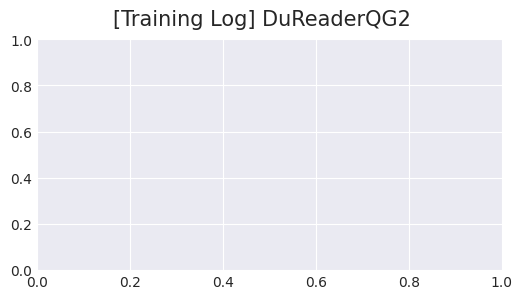

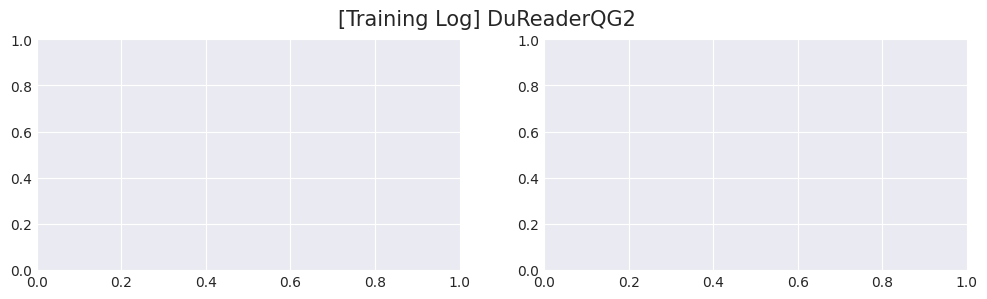

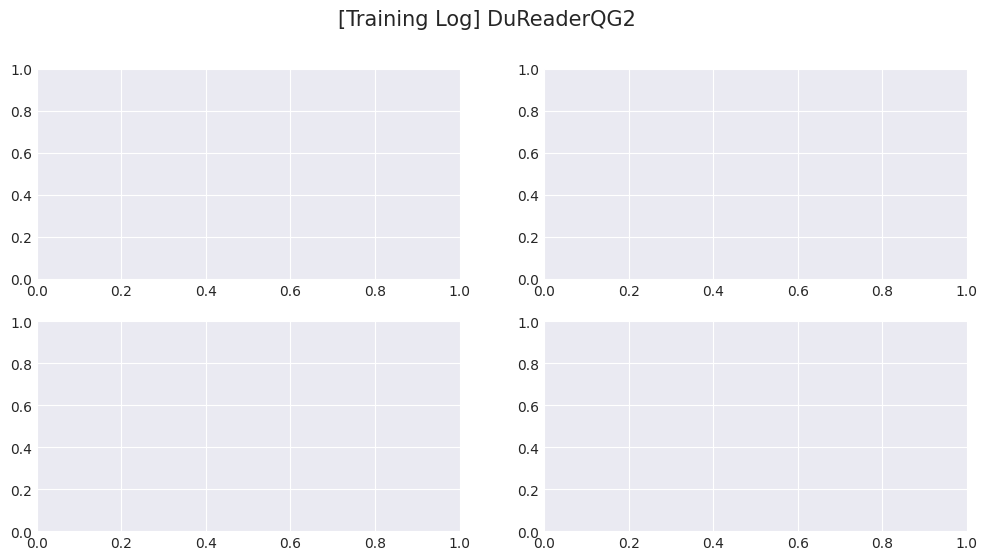

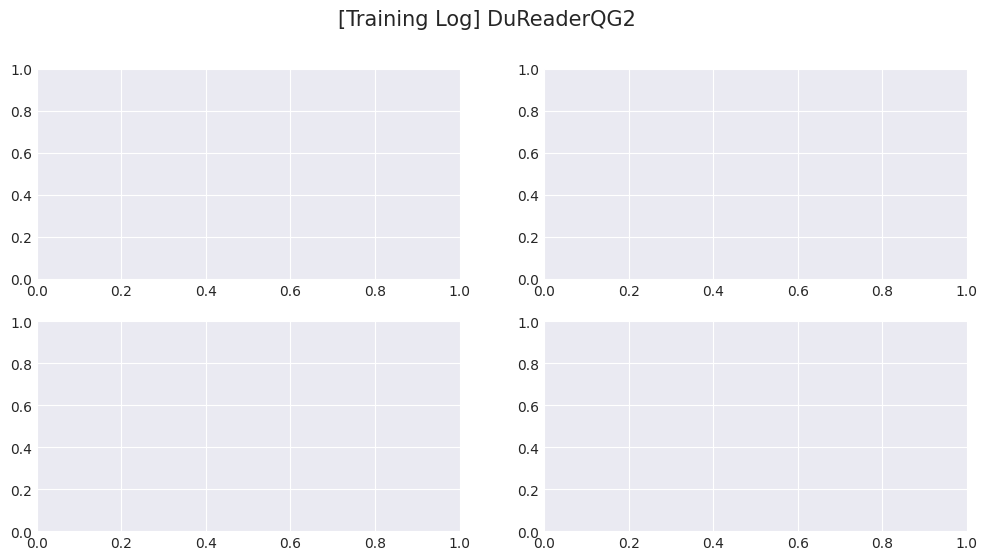

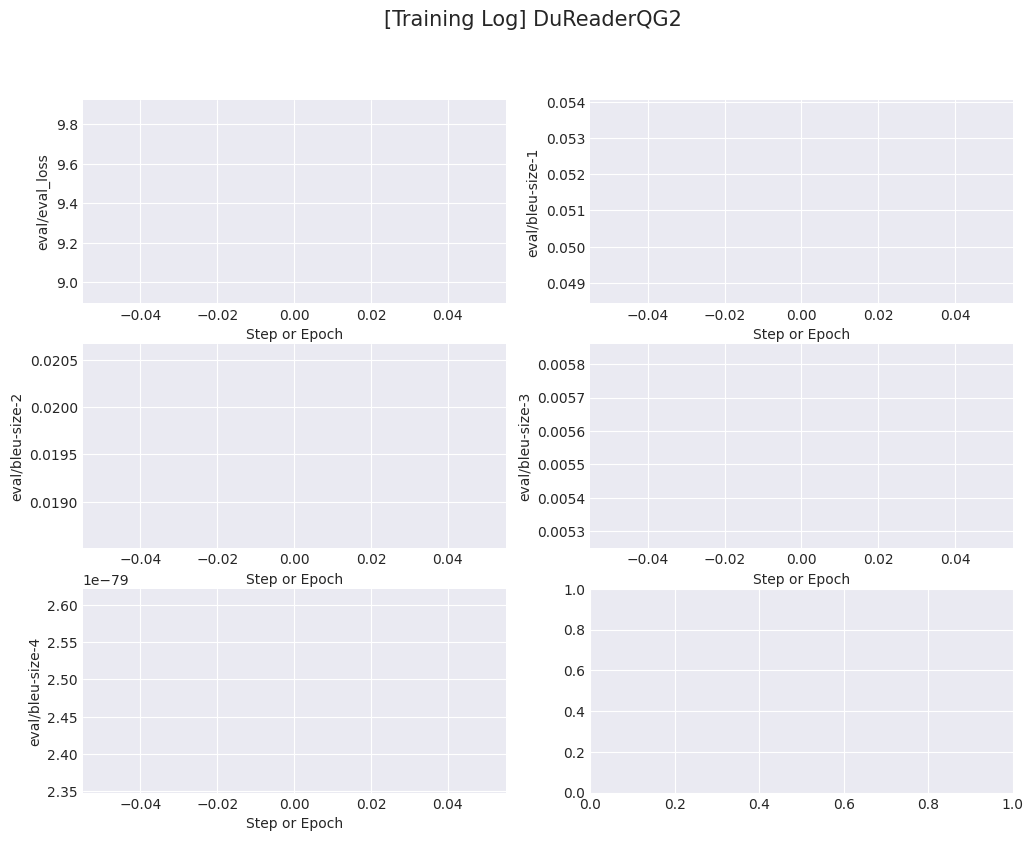

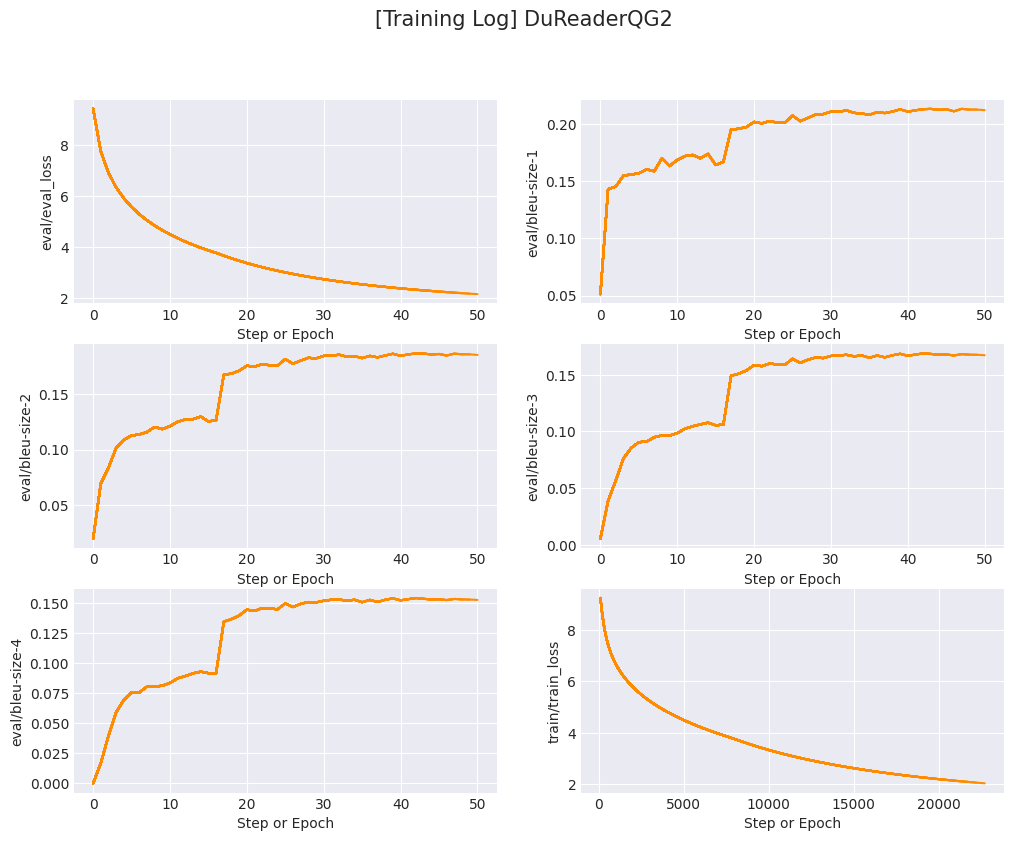

In [2]:
from iTrainingLogger import iSummaryWriter
writer = iSummaryWriter(log_path='logs/DuReaderQG2', log_name='DuReaderQG2')
def train_loop(dataloader, model, optimizer, lr_scheduler, epoch):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)
    model.train()
    for batch, batch_data in enumerate(dataloader, start=1):
        batch_data = batch_data.to(device)
        outputs = model(**batch_data)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_losses.append(loss.item())
        loss_avg = sum(train_losses) / len(train_losses)
        progress_bar.set_description(f'loss: {loss_avg:>7f}')
        progress_bar.update(1)
        if len(train_losses) % 100 == 0:
            writer.add_scalar('train/train_loss', loss_avg, finish_batch_num + batch)


def test_loop(dataloader, model, epoch):
    max_target_length = 32
    bleu_evaluators = [BLEU(n_size=i+1) for i in range(4)]
    preds, labels = [], []
    model.eval()
    a= True
    for batch_data in tqdm(dataloader):
        batch_data = batch_data.to(device)
        with torch.no_grad():
            batch_data = batch_data.to(device)
            outputs = model(**batch_data)
            loss = outputs.loss
            generated_tokens = model.generate(
                batch_data["input_ids"],
                attention_mask=batch_data["attention_mask"],
                max_length=max_target_length,
                num_beams=4,
                no_repeat_ngram_size=2,
                eos_token_id=tokenizer.eos_token_id
            ).cpu().numpy()
            test_losses.append(loss.item())
        
        if isinstance(generated_tokens, tuple):
            generated_tokens = generated_tokens[0]
        label_tokens = batch_data["labels"].cpu().numpy()
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
        if a:
            print(decoded_preds)
            a=False
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)
        for bleu_evaluator in bleu_evaluators:
            for pred,label in zip(decoded_preds,decoded_labels):
                bleu_evaluator.add_instance(prediction=pred.strip(), references=[label.strip()])
    loss_avg = sum(test_losses) / len(test_losses)
    bleu1, bleu2, bleu3, bleu4 = [bleu.compute() for bleu in bleu_evaluators]
    writer.add_scalar('eval/eval_loss', loss_avg, epoch)
    writer.add_scalar('eval/bleu-size-1', bleu1, epoch)
    writer.add_scalar('eval/bleu-size-2', bleu2, epoch)
    writer.add_scalar('eval/bleu-size-3', bleu3, epoch)
    writer.add_scalar('eval/bleu-size-4', bleu4, epoch)
    writer.record()
    return bleu4    
learning_rate = 5e-5
epoch_num = 50
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
# optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=epoch_num*len(train_dataloader),
)
best_bleu4 = 0.
test_loop(valid_dataloader, model, 0)
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1)
    bleu4 = test_loop(valid_dataloader, model, t+1)
    print(bleu4)
    if bleu4 > best_bleu4:
        best_bleu4 = bleu4
        cur_save_dir = "model_best2"
        if not os.path.exists(cur_save_dir):
            os.makedirs(cur_save_dir)
        model.save_pretrained(os.path.join(cur_save_dir))
        tokenizer.save_pretrained(os.path.join(cur_save_dir))